## House price prediction

- Data understanding and exploration
- Data Visualisation 
- Data preparation
- Feature Selection with RFE
- Model building and evaluation with LinearRegression
- Apply regularization using Lasso and Ridge

### Data understanding and exploration
    1. Load the data
    2. Handle Nan in columns either by deleting the columns or imputing them
    3. Apply log transformation for the predictor variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the the data
df= pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# check the percentage of nulls in a column
#Printing columns only with non zero NA's
nan_columns=df.isna().any()
cols=df.columns[nan_columns]
round((df[cols].isnull().sum()/len(df.index))*100,2)

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [5]:
# Nan replacement 
def nan_replacement(column_name,default_val):
    df[column_name].replace(np.nan, default_val,inplace=True)

In [6]:
# replaced column Nan with following values
nan_replacement('Alley','No Alley')
nan_replacement('MasVnrType','None')
nan_replacement('MasVnrArea',0)
nan_replacement('BsmtExposure','No Basement')
nan_replacement('BsmtFinType1','No Basement')
nan_replacement('BsmtFinType2','No Basement')
nan_replacement('BsmtQual','No Basement')
nan_replacement('BsmtCond','No Basement')
nan_replacement('FireplaceQu','No Fireplace')
nan_replacement('GarageType','No Garage')
nan_replacement('GarageFinish','No Garage')
nan_replacement('GarageQual','No Garage')
nan_replacement('GarageCond','No Garage')
nan_replacement('MiscFeature','None')
nan_replacement('Fence','No Fence')
nan_replacement('PoolQC','No Pool')

In [7]:
# check the percentage of nulls in a column
#Printing columns only with non zero NA's
nan_columns=df.isna().any()
cols=df.columns[nan_columns]
df[cols].isnull().sum()

LotFrontage    259
Electrical       1
GarageYrBlt     81
dtype: int64

In [8]:
df.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [9]:
# Imputing LotFrontage with Median
imputeval=df.LotFrontage.median()
nan_replacement('LotFrontage',imputeval)

In [10]:
# drop row not having Electrical 
df= df[~(df.Electrical.isna())]

In [11]:
df.shape

(1459, 81)

In [12]:
# dropping GarageYrBlt
df.drop(columns='GarageYrBlt',inplace=True)

In [13]:
# No column has missing null values
df.columns.isnull().sum()

0

In [14]:
# dropping Id as all values are unique
df.drop(columns='Id',inplace=True)

In [15]:
# encode with only 2 types
df['Street']= df.Street.map({'Pave':0,'Grvl':1})
df['Utilities']= df.Utilities.map({'AllPub':0,'NoSeWa':1})
df['CentralAir']=df.CentralAir.map({'Y':0,'N':1})

In [16]:
#ordinal columns
ordinal_cols=['ExterQual', 'ExterCond','HeatingQC','KitchenQual']

In [17]:
def ordinalCategColToNumeric(cols,df=df):
    for col in cols:
        df[col]=df[col].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
        df[col]=df[col].fillna(0).astype(np.int64)

In [18]:
ordinalCategColToNumeric(ordinal_cols)

In [19]:
# Custom method to plot numeric columns which has scatterplot of column vs Saleprice and 
#to check the distribution of column using
# distplot and boxplot
def plotNumericCols(column, figsize=(16,4),rotation =0):
    fig,axes=plt.subplots(1,2,figsize=figsize)
    sns.scatterplot(x=df[column],y=df.SalePrice,ax=axes[0])
    sns.boxplot(x=df[column],ax=axes[1])
    axes[0].title.set_text('Saleprice vs '+column)
    axes[1].title.set_text('Distribution of '+column)
    plt.show()

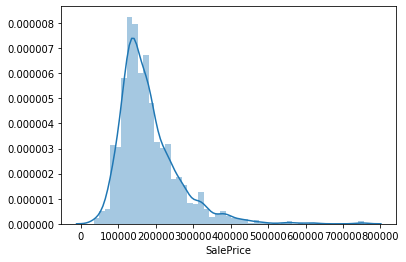

In [20]:
sns.distplot(df.SalePrice)

####  As the SalePrice is positively skewed , we will apply log transformation.

In [21]:
df.SalePrice=df.SalePrice.apply(lambda x: np.log(x))

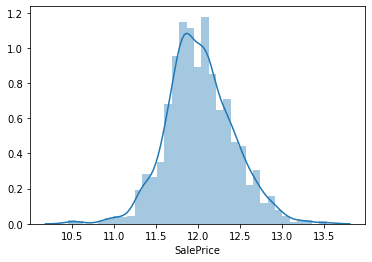

In [22]:
sns.distplot(df.SalePrice)

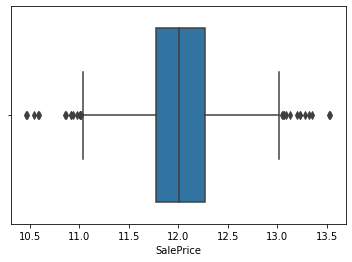

In [23]:
sns.boxplot(df.SalePrice)

In [24]:
# recursively remove the outliers
def removeOutliers(column_name,df):
    flag=False
    while ~flag:
        Q1=np.percentile(df[column_name],25)
        Q3=np.percentile(df[column_name],75)
        IQR=Q3-Q1
        upperFence= Q3+(1.5*IQR)
        lowerFence=Q1-(1.5*IQR)
        temp_df= df[(df[column_name]>=lowerFence) & (df[column_name]<=upperFence)]
        if (len(df)-len(temp_df)) ==0:
            return df
        else:
            df=temp_df

In [25]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [26]:
df=removeOutliers('SalePrice',df)

In [27]:
df.shape

(1430, 79)

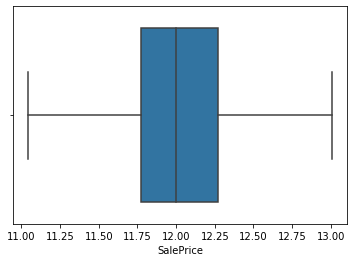

In [28]:
sns.boxplot(df.SalePrice)

There are no outliers now in SalePrice

### Data Exploration
    1.Plot scatterplot and boxplot for numeric columns
    2.Plot boxplot and countplots for non-numeric columns

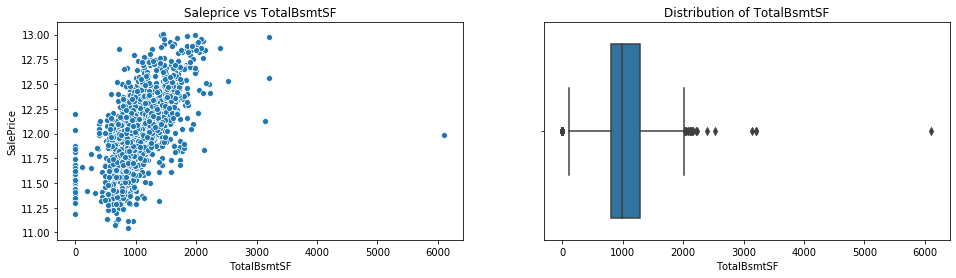

In [29]:
plotNumericCols('TotalBsmtSF')

Values after 3000 are too far away from the whiskers , Hence dropping them

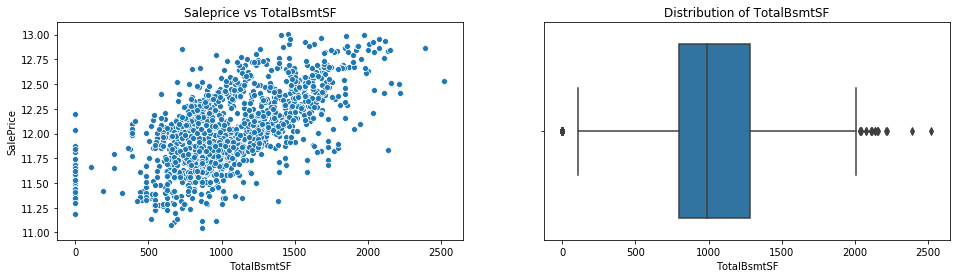

In [30]:
df= df[df.TotalBsmtSF <3000]
plotNumericCols('TotalBsmtSF')

With increase in total basement sf, sale price also increases.

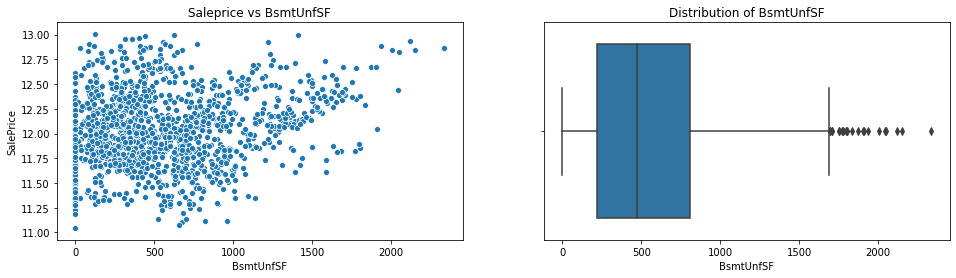

In [31]:
plotNumericCols('BsmtUnfSF')

As BsmntUnfSF increases , saleprice also increases

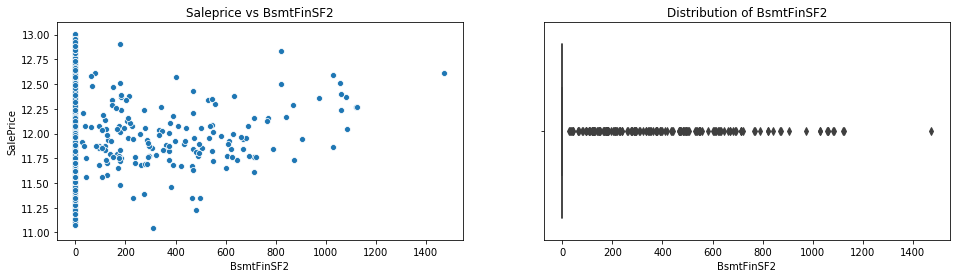

In [32]:
plotNumericCols('BsmtFinSF2')

Looks like very few rows have non zero values for BsmtFinSF2 and no pattern seen.

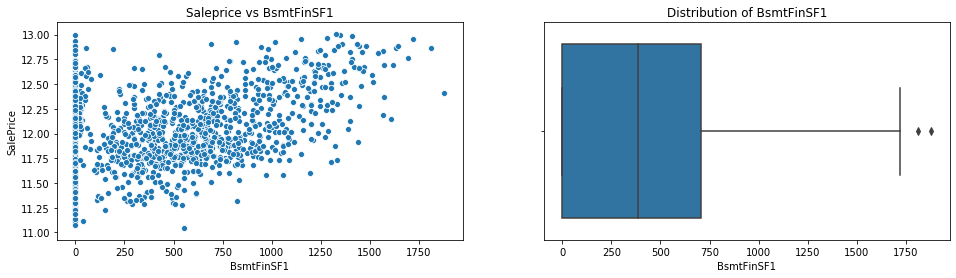

In [33]:
plotNumericCols('BsmtFinSF1')

With increase in BsmtFinSF1, sale price also increases

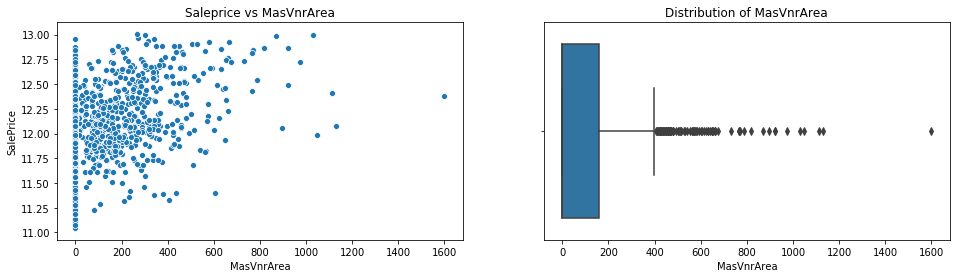

In [34]:
plotNumericCols('MasVnrArea')

Most of the rows have MasVnrArea as zero and with increase in MasVnrArea, SalePrice also increases

In [35]:
df['remodelledAge']= df.YearRemodAdd.apply(lambda x : 2020-x)
df.drop(columns=['YearRemodAdd'],inplace=True)

As YearRemodAdd increases SalePrice also increases

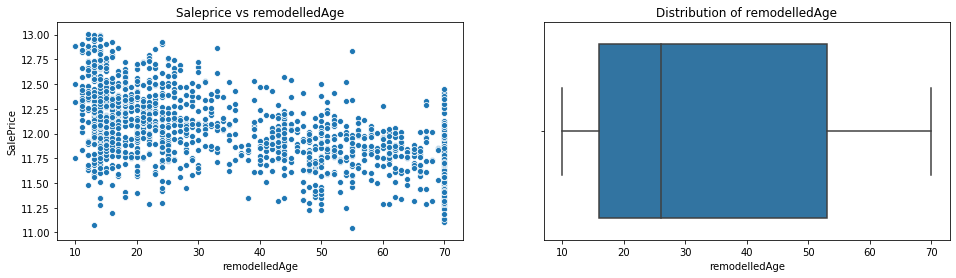

In [36]:
plotNumericCols('remodelledAge')

In [37]:
df['age']= df.YearBuilt.apply(lambda x : 2020-x)
df.drop(columns=['YearBuilt'],inplace=True)

As YearBuilt increases SalePrice also increases

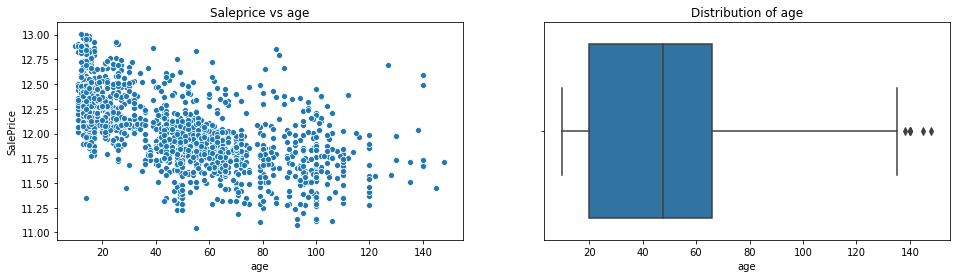

In [38]:
plotNumericCols('age')

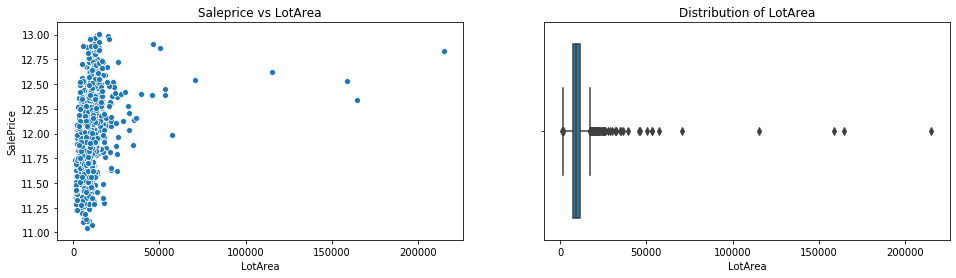

In [39]:
plotNumericCols('LotArea')

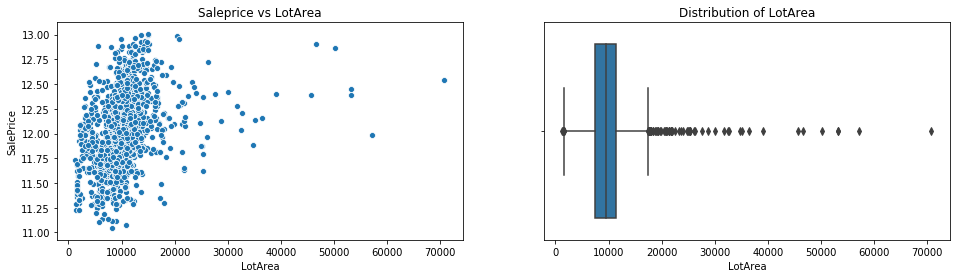

In [40]:
df= df[df.LotArea <100000]
plotNumericCols('LotArea')

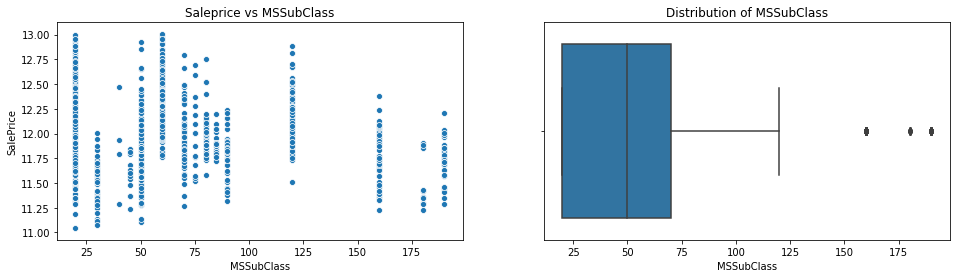

In [41]:
plotNumericCols('MSSubClass')

 Need to consider MSSubClas as categorical column instead of numeric

In [42]:
df.MSSubClass=df.MSSubClass.astype('object')

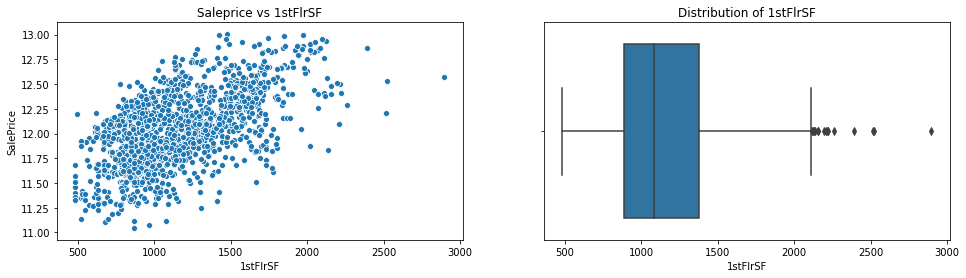

In [43]:
plotNumericCols('1stFlrSF')

1stFlrSF has outliers after 2500. Hence removing them 

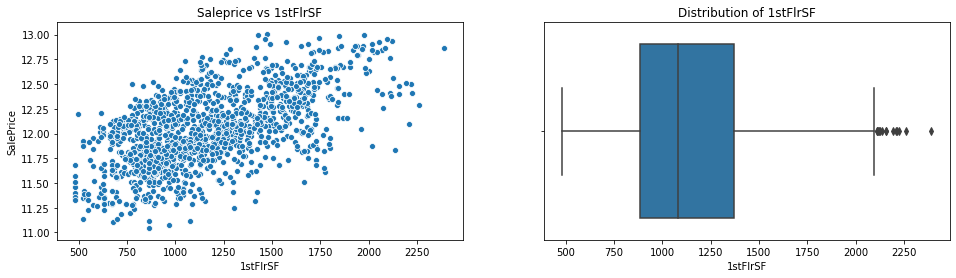

In [44]:
df=df[df['1stFlrSF'] <2500]
plotNumericCols('1stFlrSF')

As 1stFlrSF increases, SalePrice increases

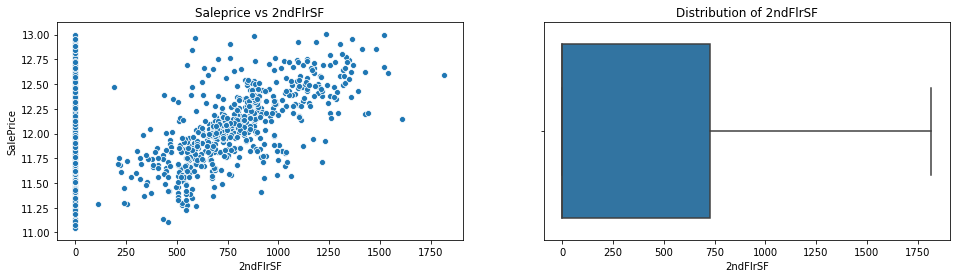

In [45]:
plotNumericCols('2ndFlrSF')

As 2ndFlrSF increases , SalePrice increases

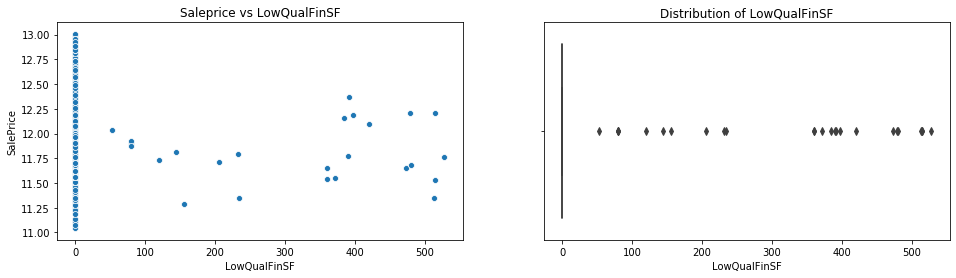

In [46]:
plotNumericCols('LowQualFinSF')

Most of the LowQualFinSF is zeros, no pattern seen for non-zeros

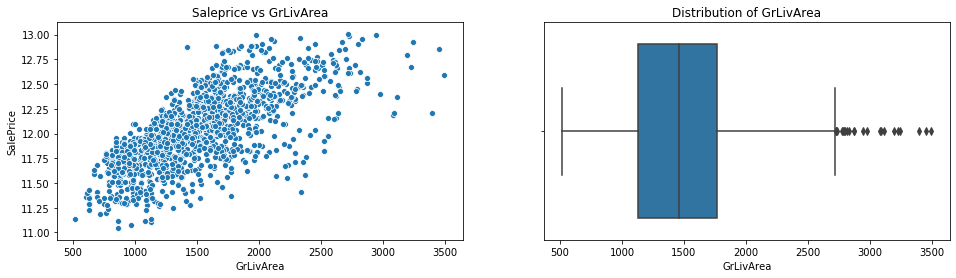

In [47]:
plotNumericCols('GrLivArea')

As GrLivArea increases SalePrice also increases.

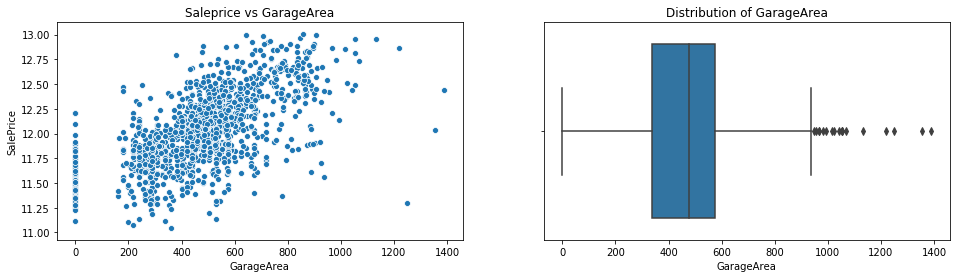

In [48]:
plotNumericCols('GarageArea')

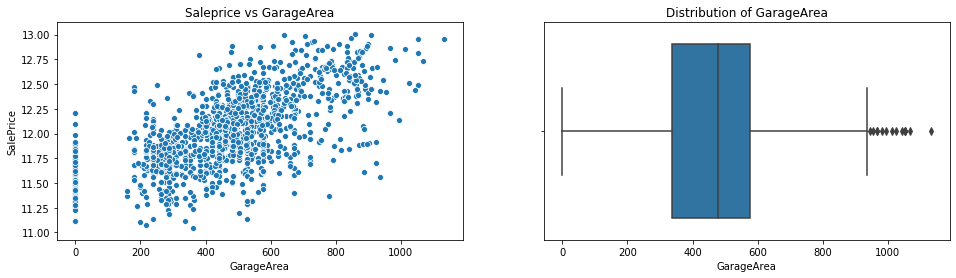

In [49]:
df= df[df.GarageArea <1200]
plotNumericCols('GarageArea')

As GarageArea increases SalePrice also increases

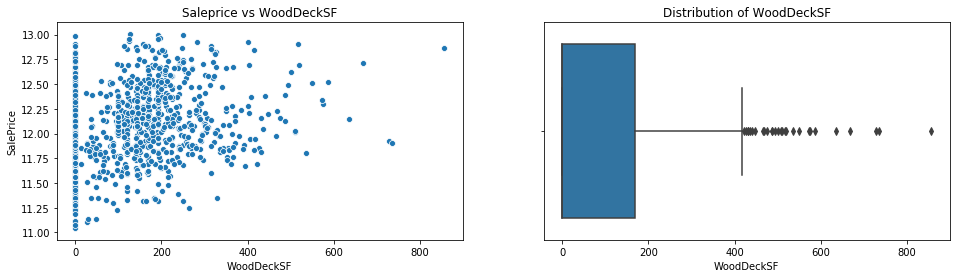

In [50]:
plotNumericCols('WoodDeckSF')

No Pattern seen for WoodDeckSF

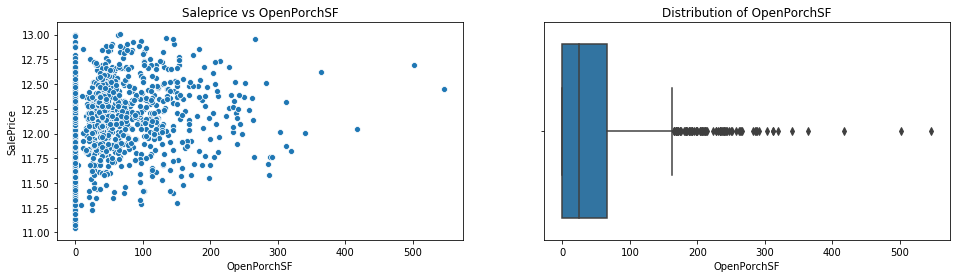

In [51]:
plotNumericCols('OpenPorchSF')

No Pattern seen for OpenPorchSF

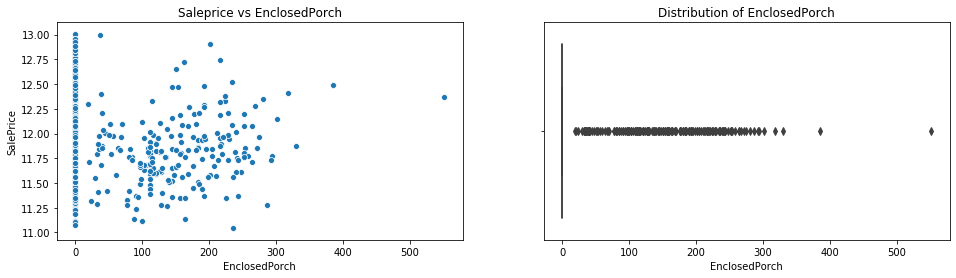

In [52]:
plotNumericCols('EnclosedPorch')

No Pattern seen for EnclosedPorch

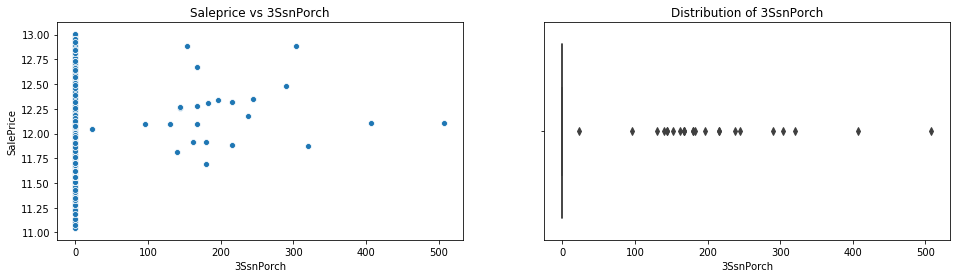

In [53]:
plotNumericCols('3SsnPorch')

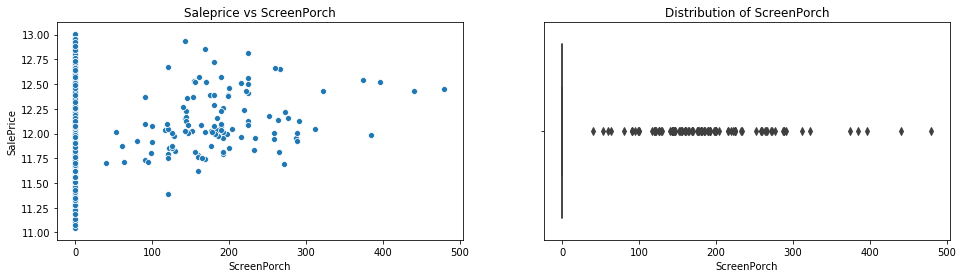

In [54]:
plotNumericCols('ScreenPorch')

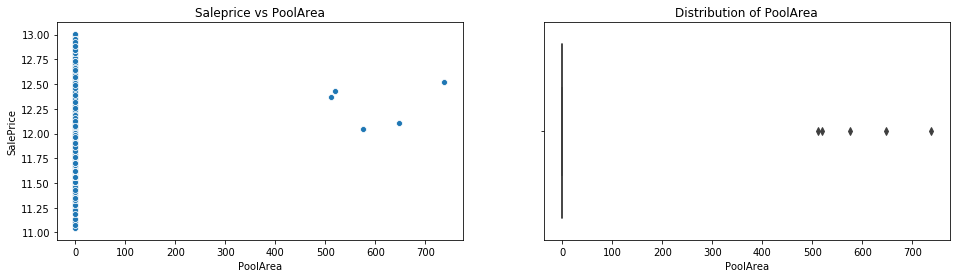

In [55]:
plotNumericCols('PoolArea')

As there are very few rows having pool , we will convert this to yes or no

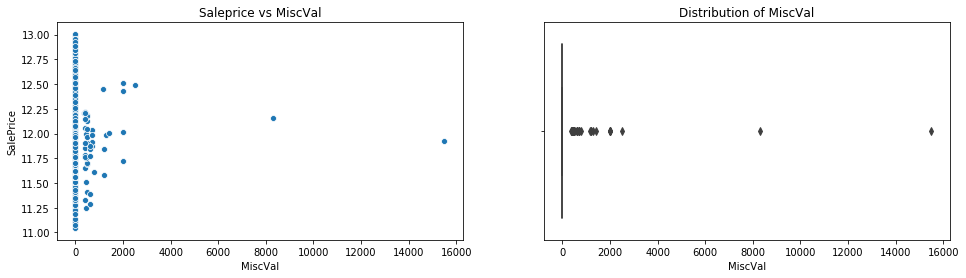

In [56]:
plotNumericCols('MiscVal')

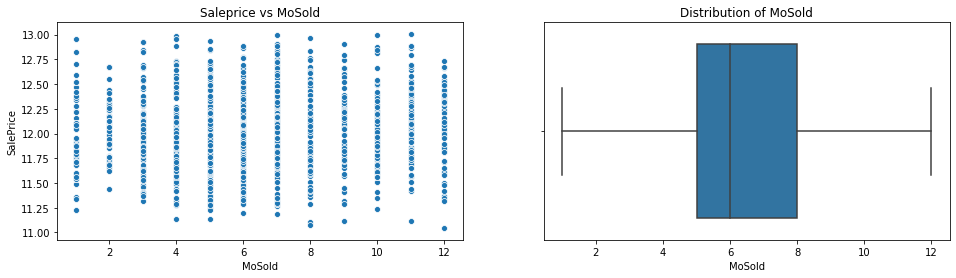

In [57]:
plotNumericCols('MoSold')

No pattern seen for month  dropping the month column

In [58]:
df.drop(columns=['MoSold'], inplace=True)

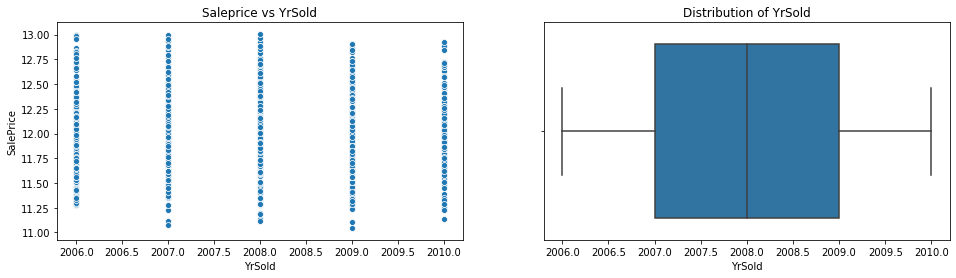

In [59]:
plotNumericCols('YrSold')

No pattern seen for Year sold . Dropping the columns

In [60]:
df.drop(columns=['YrSold'], inplace=True)

In [61]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPor

In [62]:
df_object= df.select_dtypes(include=['object'])
len(df_object.columns)

37

In [63]:
df_object.columns

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [64]:
# Custom method to check the categorical data
def plotgraphs(column, figsize=(13,4),rot=0):
    fig,axes=plt.subplots(1,2,figsize=figsize)
    sns.boxplot(x=df[column],y=df.SalePrice,ax=axes[0])
    sns.countplot(x=df[column],ax=axes[1])
    axes[0].tick_params('x',labelrotation=rot)
    axes[1].tick_params('x',labelrotation=rot)
    axes[0].title.set_text('Distribution of SalePrice with '+column)
    axes[1].title.set_text('count of '+column)
    plt.show()

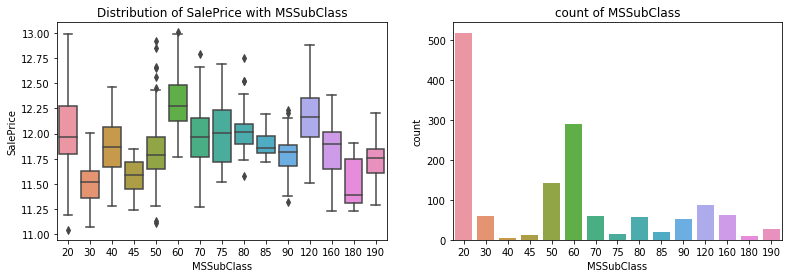

In [65]:
plotgraphs('MSSubClass')

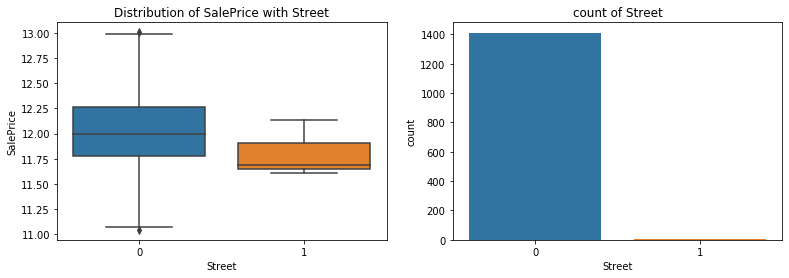

In [66]:
plotgraphs('Street')

Most of the rows have the street as 0 , so dropping the street columns

In [67]:
df.drop(columns=['Street'], inplace=True)

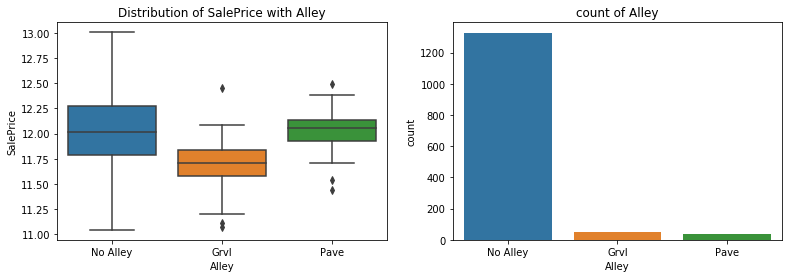

In [68]:
plotgraphs('Alley')

As Alley is highly skewed , dropping the column

In [69]:
df.drop(columns=['Alley'], inplace=True)

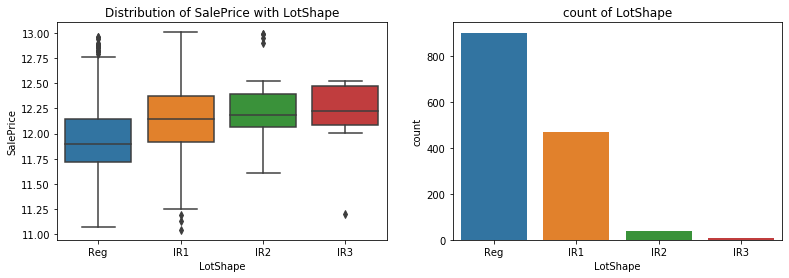

In [70]:
plotgraphs('LotShape')

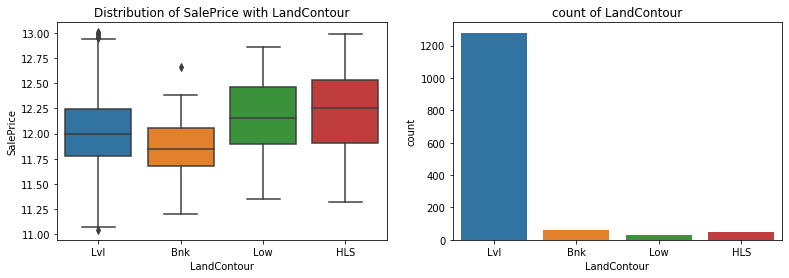

In [71]:
plotgraphs('LandContour')

As most of the rows have Lvl, dropping the column

In [72]:
df.drop(columns=['LandContour'],inplace=True)

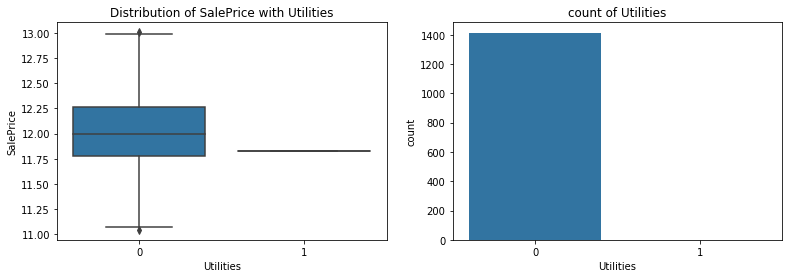

In [73]:
plotgraphs('Utilities')

Most of the rows have Utilities as 0. Dropping the column

In [74]:
df.drop(columns=['Utilities'], inplace=True)

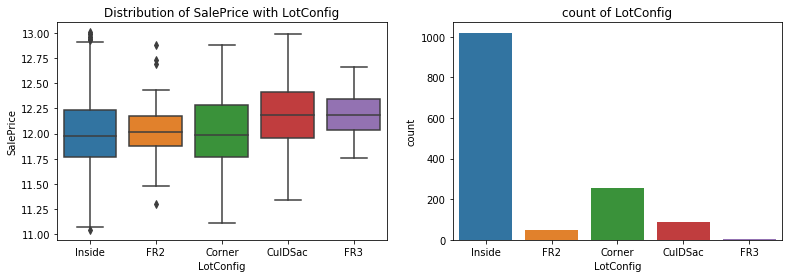

In [75]:
plotgraphs('LotConfig')

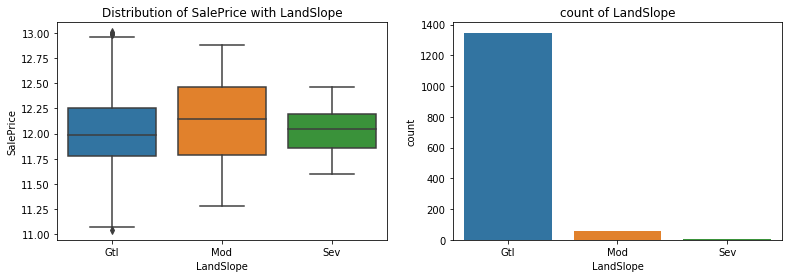

In [76]:
plotgraphs('LandSlope')

LandSlope column has Gtl value for most ot columns. Hence dropping the column

In [77]:
df.drop(columns=['LandSlope'], inplace=True)

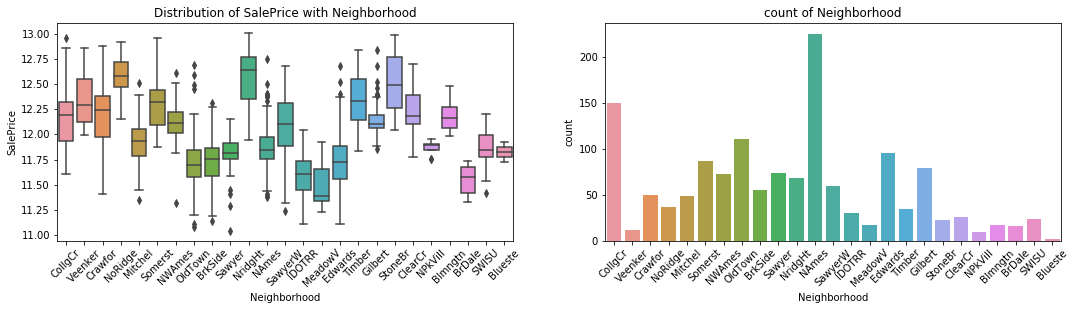

In [78]:
plotgraphs('Neighborhood',figsize=(18,4),rot=45)

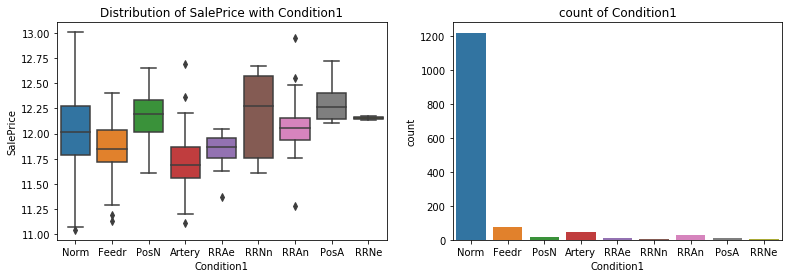

In [79]:
plotgraphs('Condition1')

Most of the rows have Norm for condition1 . Hence dropping the column

In [80]:
df.drop(columns=['Condition1'],inplace=True)

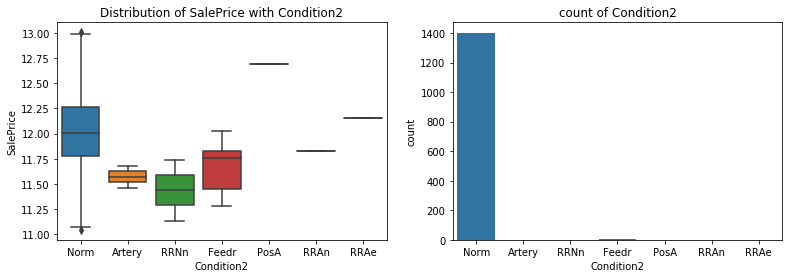

In [81]:
plotgraphs('Condition2')

In [82]:
# droping the condition 2 as most of them have rows as norm
df.drop(columns=['Condition2'],inplace=True)

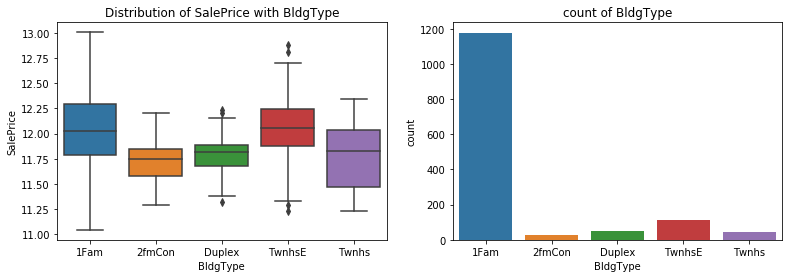

In [83]:
plotgraphs('BldgType')

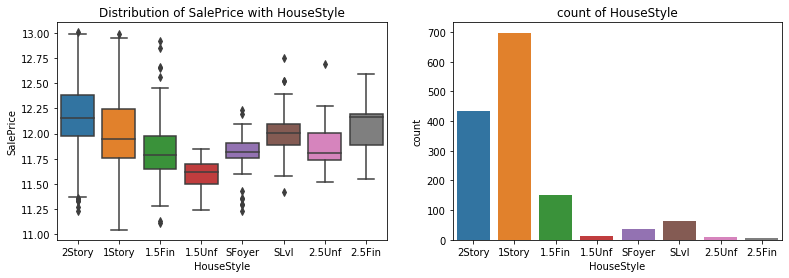

In [84]:
plotgraphs('HouseStyle')

In [85]:
df.HouseStyle.value_counts()

1Story    698
2Story    433
1.5Fin    151
SLvl       64
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      7
Name: HouseStyle, dtype: int64

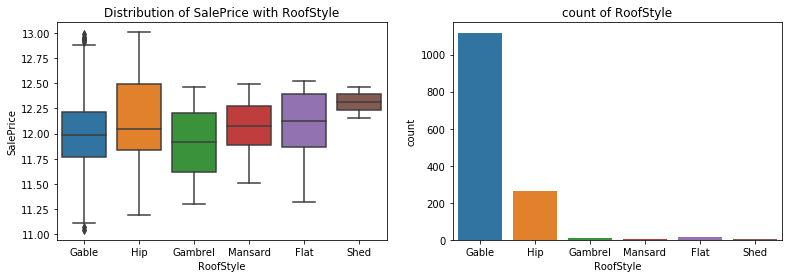

In [86]:
plotgraphs('RoofStyle')

As, data is skewed , Dropping the column.

In [87]:
df.drop(columns=['RoofStyle'],inplace=True)

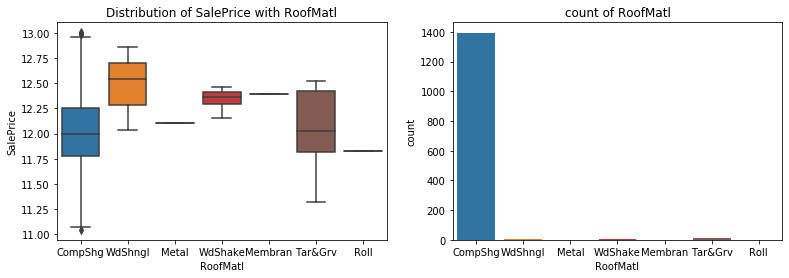

In [88]:
plotgraphs('RoofMatl')

In [89]:
df.drop(columns=['RoofMatl'],inplace=True)

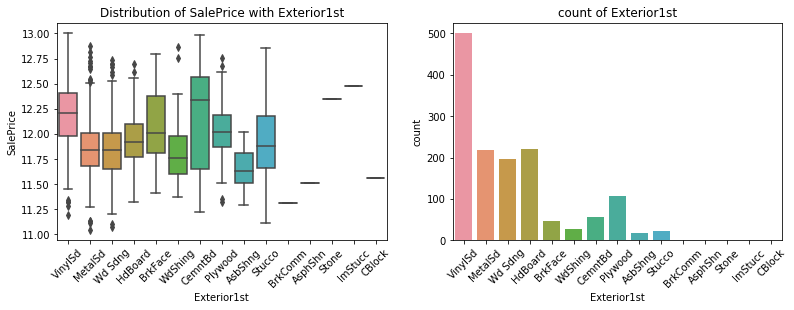

In [90]:
plotgraphs('Exterior1st',rot=45)

In [91]:
df.Exterior1st.value_counts()

VinylSd    501
HdBoard    220
MetalSd    218
Wd Sdng    197
Plywood    106
CemntBd     56
BrkFace     46
WdShing     26
Stucco      23
AsbShng     17
ImStucc      1
AsphShn      1
CBlock       1
BrkComm      1
Stone        1
Name: Exterior1st, dtype: int64

In [92]:
# Considering the types having count less than 40 as others
otherList=['ImStucc','CBlock','AsphShn','BrkComm','Stone','AsbShng','Stucco','WdShing']
df.Exterior1st=df.Exterior1st.apply(lambda x : 'Others' if x in otherList else x)
df.Exterior1st.value_counts()

VinylSd    501
HdBoard    220
MetalSd    218
Wd Sdng    197
Plywood    106
Others      71
CemntBd     56
BrkFace     46
Name: Exterior1st, dtype: int64

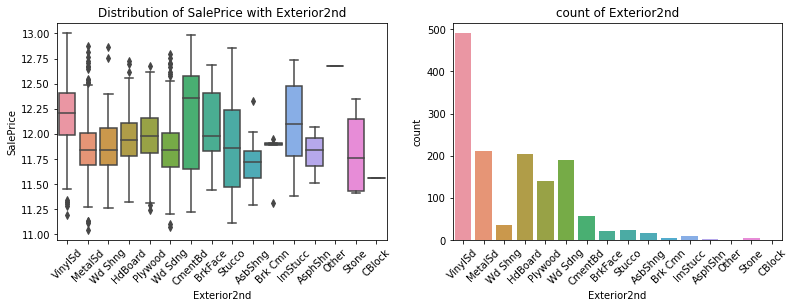

In [93]:
plotgraphs('Exterior2nd',rot=45)

In [94]:
df.Exterior2nd.value_counts()

VinylSd    491
MetalSd    212
HdBoard    203
Wd Sdng    191
Plywood    140
CmentBd     56
Wd Shng     36
Stucco      24
BrkFace     21
AsbShng     17
ImStucc      9
Brk Cmn      6
Stone        4
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [95]:
# Considering the types having count less than 40 as others
otherList=['ImStucc','CBlock','AsphShn','Brk Cmn','Stone','AsbShng','BrkFace','Stucco','Wd Shng']
df.Exterior2nd=df.Exterior2nd.apply(lambda x : 'Other' if x in otherList else x)
df.Exterior2nd.value_counts()

VinylSd    491
MetalSd    212
HdBoard    203
Wd Sdng    191
Plywood    140
Other      122
CmentBd     56
Name: Exterior2nd, dtype: int64

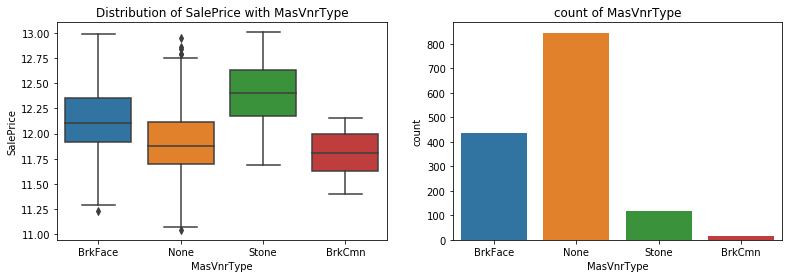

In [96]:
plotgraphs('MasVnrType')

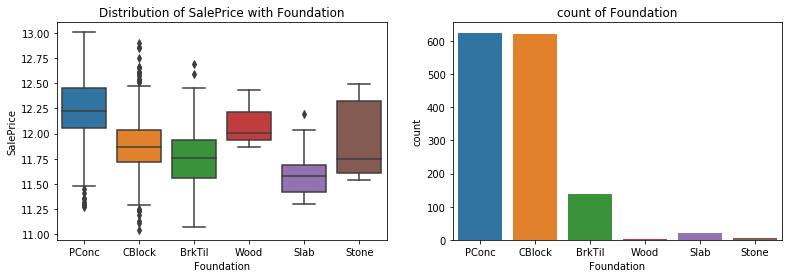

In [97]:
plotgraphs('Foundation')

In [98]:
otherList=['Wood','Slab','Stone']
df.Foundation=df.Foundation.apply(lambda x : 'Other' if x in otherList else x)
df.Foundation.value_counts()

PConc     625
CBlock    620
BrkTil    139
Other      31
Name: Foundation, dtype: int64

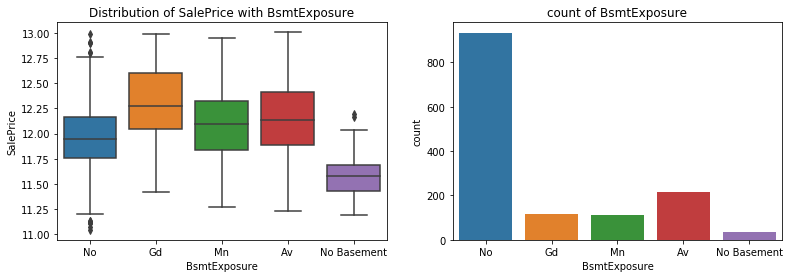

In [99]:
plotgraphs('BsmtExposure')

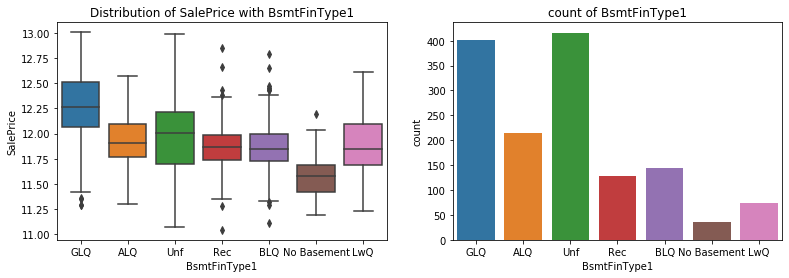

In [100]:
plotgraphs('BsmtFinType1')

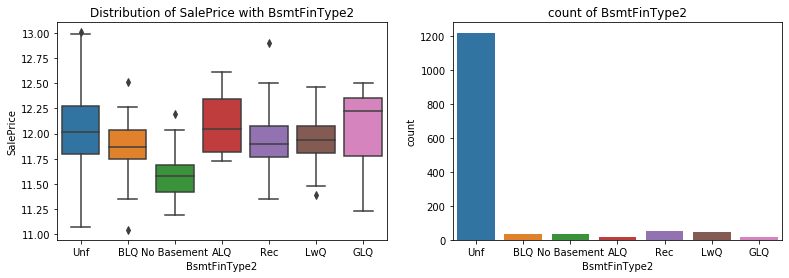

In [101]:
plotgraphs('BsmtFinType2')

AS column values are highly skewed , dropping the column

In [102]:
df.drop(columns='BsmtFinType2',inplace=True)

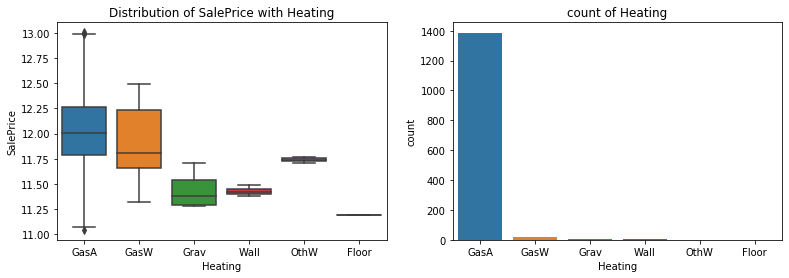

In [103]:
plotgraphs('Heating')

AS column values are highly skewed , dropping the column

In [104]:
df.drop(columns=['Heating'], inplace=True)

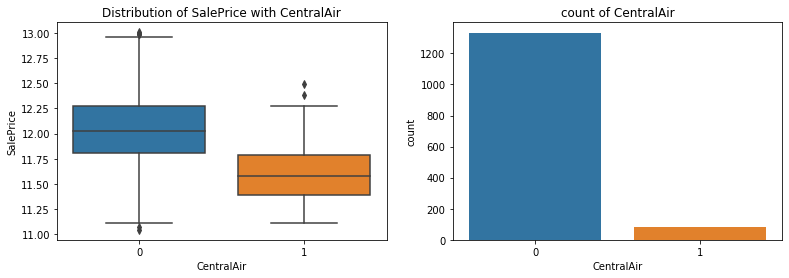

In [105]:
plotgraphs('CentralAir')

AS column values are highly skewed , dropping the column

In [106]:
df.drop(columns=['CentralAir'], inplace=True)

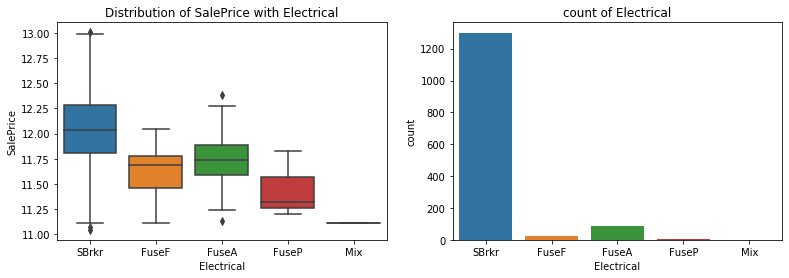

In [107]:
plotgraphs('Electrical')

AS column values are highly skewed , dropping the column

In [108]:
df.drop(columns=['Electrical'], inplace=True)

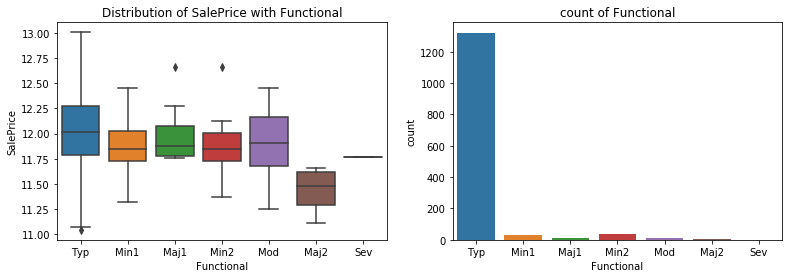

In [109]:
plotgraphs('Functional')

AS column values are highly skewed , dropping the column

In [110]:
df.drop(columns=['Functional'], inplace=True)

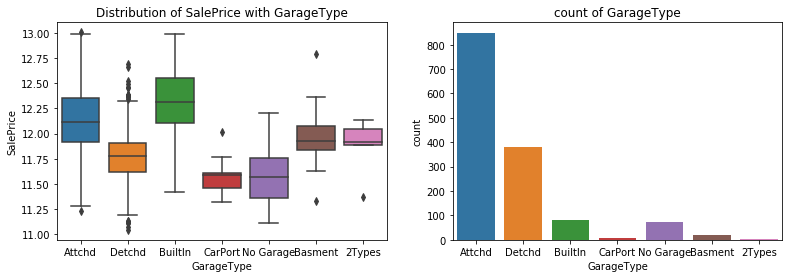

In [111]:
plotgraphs('GarageType')

In [112]:
otherList=['No Garage','Basement','2Types','CarPort']
df.GarageType=df.GarageType.apply(lambda x : 'Other' if x in otherList else x)
df.GarageType.value_counts()

Attchd     849
Detchd     381
Other       86
BuiltIn     81
Basment     18
Name: GarageType, dtype: int64

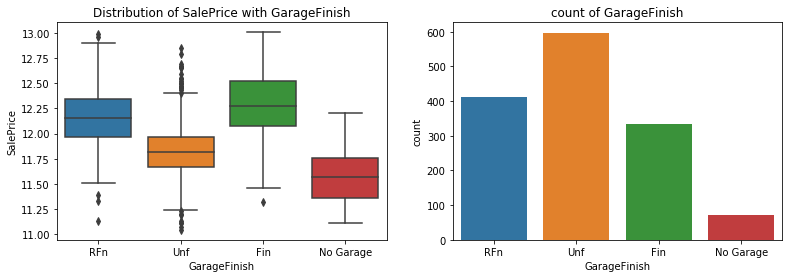

In [113]:
plotgraphs('GarageFinish')

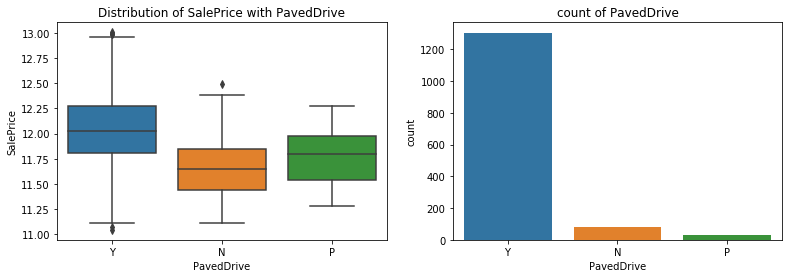

In [114]:
plotgraphs('PavedDrive')

AS column values are highly skewed , dropping the column

In [115]:
df.drop(columns=['PavedDrive'], inplace=True)

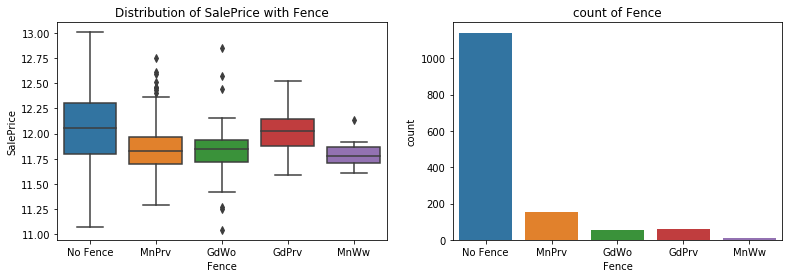

In [116]:
plotgraphs('Fence')

AS column values are highly skewed , dropping the column

In [117]:
df.drop(columns=['Fence'], inplace=True)

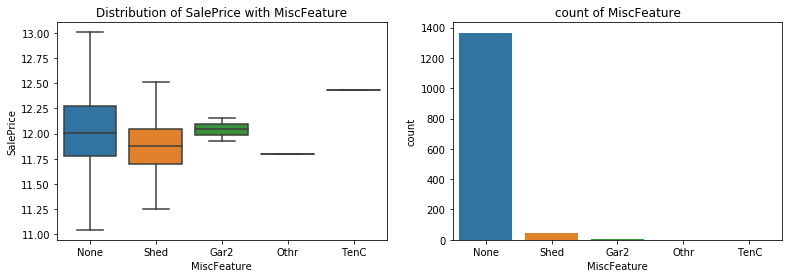

In [118]:
plotgraphs('MiscFeature')

In [119]:
df.drop(columns=['MiscFeature'],inplace=True)

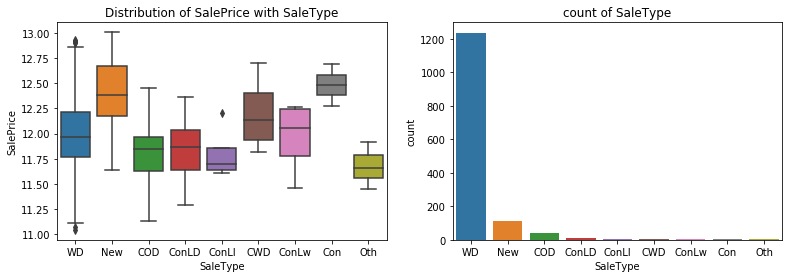

In [120]:
plotgraphs('SaleType')

In [121]:
df.SaleType.value_counts()

WD       1237
New       112
COD        41
ConLD       8
ConLw       4
CWD         4
ConLI       4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [122]:
# Considering the types having count less than 40 as others
otherList=['ConLI','CWD','ConLw','Oth','Con']
df.SaleType=df.SaleType.apply(lambda x : 'Other' if x in otherList else x)
df.SaleType.value_counts()

WD       1237
New       112
COD        41
Other      17
ConLD       8
Name: SaleType, dtype: int64

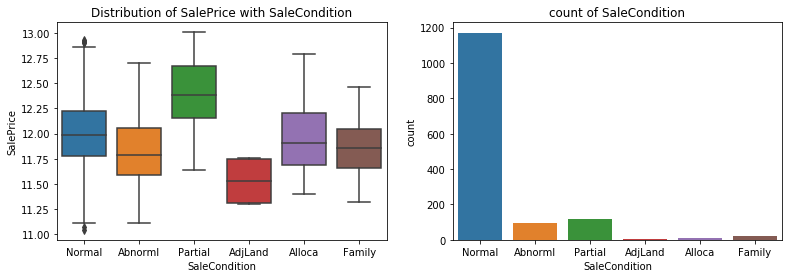

In [123]:
plotgraphs('SaleCondition')

### Create dummies for object dtypes

In [124]:
df_numeric= df.select_dtypes(include=['float64','int64'])

In [125]:
len(df_numeric.columns)

37

In [126]:
df_object= df.select_dtypes(include=['object'])

In [127]:
len(df_object.columns)

23

In [128]:
# create dummies for categorical variables
df_dummies=pd.get_dummies(df_object,drop_first=True)
df_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,PoolQC_No Pool,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [129]:
# concat numerical and dummy columns
df=df.drop(columns=list(df_object.columns),axis=1)

In [130]:
df= pd.concat([df,df_dummies],axis=1)

In [131]:
df.shape

(1415, 168)

In [132]:
y= df.pop('SalePrice')
X=df

In [133]:
X=df

In [134]:
# split test and train data
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

In [135]:
# Scale test and train data
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
cols=X_train.columns
X_train[cols]= scaler.fit_transform(X_train[cols])
X_test[cols]= scaler.transform(X_test[cols])

### RFE to select top attributes

In [136]:
from sklearn.feature_selection import RFE

In [137]:
X_train.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,PoolQC_No Pool,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.165546,0.122155,0.442280,0.510390,0.057363,0.459933,0.522222,0.231457,0.029917,0.268743,...,0.995960,0.005051,0.075758,0.009091,0.881818,0.003030,0.008081,0.016162,0.831313,0.076768
std,0.071330,0.071990,0.181811,0.156457,0.098902,0.180873,0.087147,0.229249,0.108288,0.203251,...,0.063468,0.070923,0.264744,0.094960,0.322986,0.054992,0.089575,0.126161,0.374664,0.266357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.086932,0.285714,0.428571,0.000000,0.333333,0.500000,0.000000,0.000000,0.110443,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.164384,0.116441,0.428571,0.428571,0.000000,0.333333,0.500000,0.202486,0.000000,0.230552,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.195205,0.146174,0.571429,0.571429,0.092969,0.666667,0.500000,0.384392,0.000000,0.382249,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
regression=LinearRegression()
model=RFE(regression,30).fit(X_train,y_train)
top_features= X.columns[model.support_]
top_features

Index(['LotArea', 'OverallQual', 'OverallCond', 'ExterCond', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenAbvGr',
       'KitchenQual', 'GarageCars', 'OpenPorchSF', 'ScreenPorch', 'PoolArea',
       'age', 'MSSubClass_160', 'Neighborhood_Blueste', 'Neighborhood_Crawfor',
       'Neighborhood_MeadowV', 'Exterior1st_CemntBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'PoolQC_No Pool',
       'SaleType_New', 'SaleCondition_Partial'],
      dtype='object')

In [139]:
import statsmodels.api as sm

In [140]:
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     320.7
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:43:56   Log-Likelihood:                 807.18
No. Observations:                 990   AIC:                            -1552.
Df Residuals:                     959   BIC:                            -1401.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1735      0.383     26.547      0.000       9.421      10.926
LotArea                   0.4197      0.057      7.423      0.000       0.309       0.531
OverallQual               0.4056      0.032     12.646      0.000       0.343       0.469
OverallCond               0.3516      0.028     12.777      0.000       0.298       0.406
ExterCond                -0.1440      0.044     -3.291      0.001      -0.230      -0.058
BsmtFinSF1                0.1976      0.018     11.212      0.000       0.163       0.232
TotalBsmtSF               0.2466      0.037      6.700      0.000       0.174       0.319
1stFlrSF                  0.1447      0.143      1.012      0.312      -0.136       0.425
2ndFlrSF                  0.1703      0.144      1.186      0.236      -0.111       0.452
GrLivArea                 0.5667      0.222      2.557      0.011       0.132       1.002
KitchenAbvGr             -0.1919      0.034     -5.574      0.000      -0.259      -0.124
KitchenQual               0.1359      0.023      5.785      0.000       0.090       0.182
GarageCars                0.1769      0.027      6.564      0.000       0.124       0.230
OpenPorchSF               0.1061      0.033      3.249      0.001       0.042       0.170
ScreenPorch               0.1099      0.031      3.569      0.000       0.049       0.170
PoolArea                  1.5460      0.440      3.515      0.000       0.683       2.409
age                      -0.4772      0.028    -16.787      0.000      -0.533      -0.421
MSSubClass_160           -0.1047      0.020     -5.369      0.000      -0.143      -0.066
Neighborhood_Blueste      0.1137      0.111      1.025      0.306      -0.104       0.332
Neighborhood_Crawfor      0.1554      0.019      8.257      0.000       0.118       0.192
Neighborhood_MeadowV     -0.1106      0.042     -2.663      0.008      -0.192      -0.029
Exterior1st_CemntBd      -0.2112      0.112     -1.889      0.059      -0.431       0.008
Exterior2nd_HdBoard      -0.2315      0.111     -2.094      0.036      -0.448      -0.015
Exterior2nd_MetalSd      -0.2004      0.111     -1.811      0.070      -0.418       0.017
Exterior2nd_Other        -0.1879      0.111     -1.696      0.090      -0.405       0.030
Exterior2nd_Plywood      -0.2353      0.111     -2.124      0.034      -0.453      -0.018
Exterior2nd_VinylSd      -0.2065      0.110     -1.877      0.061      -0.422       0.009
Exterior2nd_Wd Sdng      -0.2074      0.111     -1.874      0.061      -0.425       0.010
PoolQC_No Pool            1.2693      0.366      3.465      0.001       0.550       1.988
SaleType_New              0.5336      0.112      4.746      0.000       0.313       0.754
SaleCondition_Partial    -0.4673      0.112     -4.188      0.000      -0.686      -0.248
=======================

#### p-value for 1stFlrSF is greater than 0.05 . Hence we are not considering the column

In [141]:
top_features=top_features.drop('1stFlrSF')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     331.7
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:43:57   Log-Likelihood:                 806.65
No. Observations:                 990   AIC:                            -1553.
Df Residuals:                     960   BIC:                            -1406.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1258      0.380     26.624      0.000       9.379      10.872
LotArea                   0.4233      0.056      7.501      0.000       0.313       0.534
OverallQual               0.4072      0.032     12.709      0.000       0.344       0.470
OverallCond               0.3531      0.027     12.851      0.000       0.299       0.407
ExterCond                -0.1407      0.044     -3.226      0.001      -0.226      -0.055
BsmtFinSF1                0.1978      0.018     11.227      0.000       0.163       0.232
TotalBsmtSF               0.2505      0.037      6.844      0.000       0.179       0.322
2ndFlrSF                  0.0289      0.033      0.869      0.385      -0.036       0.094
GrLivArea                 0.7850      0.051     15.280      0.000       0.684       0.886
KitchenAbvGr             -0.1884      0.034     -5.501      0.000      -0.256      -0.121
KitchenQual               0.1355      0.023      5.769      0.000       0.089       0.182
GarageCars                0.1808      0.027      6.780      0.000       0.129       0.233
OpenPorchSF               0.1060      0.033      3.248      0.001       0.042       0.170
ScreenPorch               0.1123      0.031      3.659      0.000       0.052       0.173
PoolArea                  1.6070      0.436      3.688      0.000       0.752       2.462
age                      -0.4808      0.028    -17.044      0.000      -0.536      -0.425
MSSubClass_160           -0.1057      0.019     -5.428      0.000      -0.144      -0.068
Neighborhood_Blueste      0.1137      0.111      1.025      0.306      -0.104       0.332
Neighborhood_Crawfor      0.1561      0.019      8.298      0.000       0.119       0.193
Neighborhood_MeadowV     -0.1103      0.042     -2.654      0.008      -0.192      -0.029
Exterior1st_CemntBd      -0.2113      0.112     -1.889      0.059      -0.431       0.008
Exterior2nd_HdBoard      -0.2320      0.111     -2.098      0.036      -0.449      -0.015
Exterior2nd_MetalSd      -0.2012      0.111     -1.819      0.069      -0.418       0.016
Exterior2nd_Other        -0.1874      0.111     -1.691      0.091      -0.405       0.030
Exterior2nd_Plywood      -0.2358      0.111     -2.129      0.034      -0.453      -0.018
Exterior2nd_VinylSd      -0.2073      0.110     -1.885      0.060      -0.423       0.009
Exterior2nd_Wd Sdng      -0.2077      0.111     -1.877      0.061      -0.425       0.009
PoolQC_No Pool            1.3254      0.362      3.661      0.000       0.615       2.036
SaleType_New              0.5328      0.112      4.739      0.000       0.312       0.753
SaleCondition_Partial    -0.4669      0.112     -4.184      0.000      -0.686      -0.248
==============================================================================
Omnibus:                      256.

#### p-value for Neighborhood_Blueste is greater than 0.05 . Hence we are not considering the column

In [142]:
top_features=top_features.drop('Neighborhood_Blueste')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     343.5
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:02   Log-Likelihood:                 806.11
No. Observations:                 990   AIC:                            -1554.
Df Residuals:                     961   BIC:                            -1412.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1235      0.380     26.618      0.000       9.377      10.870
LotArea                   0.4223      0.056      7.485      0.000       0.312       0.533
OverallQual               0.4068      0.032     12.697      0.000       0.344       0.470
OverallCond               0.3531      0.027     12.849      0.000       0.299       0.407
ExterCond                -0.1368      0.043     -3.148      0.002      -0.222      -0.052
BsmtFinSF1                0.1975      0.018     11.211      0.000       0.163       0.232
TotalBsmtSF               0.2510      0.037      6.859      0.000       0.179       0.323
2ndFlrSF                  0.0292      0.033      0.877      0.381      -0.036       0.094
GrLivArea                 0.7855      0.051     15.291      0.000       0.685       0.886
KitchenAbvGr             -0.1888      0.034     -5.513      0.000      -0.256      -0.122
KitchenQual               0.1345      0.023      5.732      0.000       0.088       0.181
GarageCars                0.1817      0.027      6.814      0.000       0.129       0.234
OpenPorchSF               0.1051      0.033      3.221      0.001       0.041       0.169
ScreenPorch               0.1123      0.031      3.659      0.000       0.052       0.173
PoolArea                  1.6076      0.436      3.689      0.000       0.752       2.463
age                      -0.4814      0.028    -17.070      0.000      -0.537      -0.426
MSSubClass_160           -0.1032      0.019     -5.341      0.000      -0.141      -0.065
Neighborhood_Crawfor      0.1560      0.019      8.292      0.000       0.119       0.193
Neighborhood_MeadowV     -0.1115      0.042     -2.684      0.007      -0.193      -0.030
Exterior1st_CemntBd      -0.2114      0.112     -1.891      0.059      -0.431       0.008
Exterior2nd_HdBoard      -0.2322      0.111     -2.101      0.036      -0.449      -0.015
Exterior2nd_MetalSd      -0.2007      0.111     -1.814      0.070      -0.418       0.016
Exterior2nd_Other        -0.1874      0.111     -1.692      0.091      -0.405       0.030
Exterior2nd_Plywood      -0.2360      0.111     -2.130      0.033      -0.453      -0.019
Exterior2nd_VinylSd      -0.2075      0.110     -1.886      0.060      -0.423       0.008
Exterior2nd_Wd Sdng      -0.2077      0.111     -1.877      0.061      -0.425       0.009
PoolQC_No Pool            1.3261      0.362      3.662      0.000       0.615       2.037
SaleType_New              0.5318      0.112      4.730      0.000       0.311       0.752
SaleCondition_Partial    -0.4659      0.112     -4.176      0.000      -0.685      -0.247
==============================================================================
Omnibus:                      257.181   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarqu

#### p-value for 2ndFlrSF is greater than 0.05 . Hence we are not considering the column

In [143]:
top_features=top_features.drop('2ndFlrSF')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:02   Log-Likelihood:                 805.71
No. Observations:                 990   AIC:                            -1555.
Df Residuals:                     962   BIC:                            -1418.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.1477      0.379     26.755      0.000       9.403      10.892
LotArea                   0.4197      0.056      7.450      0.000       0.309       0.530
OverallQual               0.4089      0.032     12.800      0.000       0.346       0.472
OverallCond               0.3547      0.027     12.941      0.000       0.301       0.409
ExterCond                -0.1373      0.043     -3.159      0.002      -0.223      -0.052
BsmtFinSF1                0.1975      0.018     11.209      0.000       0.163       0.232
TotalBsmtSF               0.2293      0.027      8.504      0.000       0.176       0.282
GrLivArea                 0.8225      0.029     27.972      0.000       0.765       0.880
KitchenAbvGr             -0.1921      0.034     -5.640      0.000      -0.259      -0.125
KitchenQual               0.1332      0.023      5.689      0.000       0.087       0.179
GarageCars                0.1808      0.027      6.788      0.000       0.129       0.233
OpenPorchSF               0.1073      0.033      3.299      0.001       0.043       0.171
ScreenPorch               0.1127      0.031      3.674      0.000       0.053       0.173
PoolArea                  1.5782      0.434      3.633      0.000       0.726       2.431
age                      -0.4814      0.028    -17.071      0.000      -0.537      -0.426
MSSubClass_160           -0.1001      0.019     -5.270      0.000      -0.137      -0.063
Neighborhood_Crawfor      0.1556      0.019      8.273      0.000       0.119       0.192
Neighborhood_MeadowV     -0.1102      0.041     -2.655      0.008      -0.192      -0.029
Exterior1st_CemntBd      -0.2096      0.112     -1.875      0.061      -0.429       0.010
Exterior2nd_HdBoard      -0.2300      0.110     -2.082      0.038      -0.447      -0.013
Exterior2nd_MetalSd      -0.1981      0.111     -1.791      0.074      -0.415       0.019
Exterior2nd_Other        -0.1850      0.111     -1.670      0.095      -0.402       0.032
Exterior2nd_Plywood      -0.2344      0.111     -2.117      0.035      -0.452      -0.017
Exterior2nd_VinylSd      -0.2039      0.110     -1.855      0.064      -0.420       0.012
Exterior2nd_Wd Sdng      -0.2061      0.111     -1.863      0.063      -0.423       0.011
PoolQC_No Pool            1.3032      0.361      3.609      0.000       0.595       2.012
SaleType_New              0.5311      0.112      4.725      0.000       0.311       0.752
SaleCondition_Partial    -0.4655      0.112     -4.172      0.000      -0.684      -0.247
==============================================================================
Omnibus:                      257.501   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1295.659
Skew:                          -1.105   Prob(JB):       

#### p-value for Exterior2nd_Other is greater than 0.05 . Hence we are not considering the column

In [144]:
top_features=top_features.drop('Exterior2nd_Other')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     369.2
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:03   Log-Likelihood:                 804.28
No. Observations:                 990   AIC:                            -1555.
Df Residuals:                     963   BIC:                            -1422.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.9620      0.363     27.447      0.000       9.250      10.674
LotArea                   0.4208      0.056      7.462      0.000       0.310       0.531
OverallQual               0.4101      0.032     12.828      0.000       0.347       0.473
OverallCond               0.3550      0.027     12.940      0.000       0.301       0.409
ExterCond                -0.1371      0.043     -3.153      0.002      -0.223      -0.052
BsmtFinSF1                0.1948      0.018     11.093      0.000       0.160       0.229
TotalBsmtSF               0.2328      0.027      8.652      0.000       0.180       0.286
GrLivArea                 0.8218      0.029     27.926      0.000       0.764       0.880
KitchenAbvGr             -0.1920      0.034     -5.633      0.000      -0.259      -0.125
KitchenQual               0.1347      0.023      5.751      0.000       0.089       0.181
GarageCars                0.1813      0.027      6.800      0.000       0.129       0.234
OpenPorchSF               0.1080      0.033      3.317      0.001       0.044       0.172
ScreenPorch               0.1118      0.031      3.639      0.000       0.051       0.172
PoolArea                  1.5785      0.435      3.630      0.000       0.725       2.432
age                      -0.4832      0.028    -17.132      0.000      -0.539      -0.428
MSSubClass_160           -0.1005      0.019     -5.289      0.000      -0.138      -0.063
Neighborhood_Crawfor      0.1551      0.019      8.242      0.000       0.118       0.192
Neighborhood_MeadowV     -0.1082      0.042     -2.607      0.009      -0.190      -0.027
Exterior1st_CemntBd      -0.0278      0.025     -1.089      0.276      -0.078       0.022
Exterior2nd_HdBoard      -0.0473      0.016     -3.050      0.002      -0.078      -0.017
Exterior2nd_MetalSd      -0.0150      0.015     -1.022      0.307      -0.044       0.014
Exterior2nd_Plywood      -0.0516      0.017     -3.056      0.002      -0.085      -0.018
Exterior2nd_VinylSd      -0.0220      0.015     -1.497      0.135      -0.051       0.007
Exterior2nd_Wd Sdng      -0.0230      0.015     -1.551      0.121      -0.052       0.006
PoolQC_No Pool            1.3042      0.361      3.608      0.000       0.595       2.014
SaleType_New              0.5305      0.113      4.715      0.000       0.310       0.751
SaleCondition_Partial    -0.4661      0.112     -4.174      0.000      -0.685      -0.247
==============================================================================
Omnibus:                      256.103   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1280.706
Skew:                          -1.100   Prob(JB):                    7.91e-279
Kurtosis:                       8.119   Cond. No.                  

#### p-value for Exterior1st_CemntBd is greater than 0.05 . Hence we are not considering the column

In [145]:
top_features=top_features.drop('Exterior1st_CemntBd')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     383.8
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:04   Log-Likelihood:                 803.67
No. Observations:                 990   AIC:                            -1555.
Df Residuals:                     964   BIC:                            -1428.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.9684      0.363     27.465      0.000       9.256      10.681
LotArea                   0.4237      0.056      7.523      0.000       0.313       0.534
OverallQual               0.4097      0.032     12.815      0.000       0.347       0.472
OverallCond               0.3527      0.027     12.893      0.000       0.299       0.406
ExterCond                -0.1378      0.043     -3.168      0.002      -0.223      -0.052
BsmtFinSF1                0.1947      0.018     11.084      0.000       0.160       0.229
TotalBsmtSF               0.2306      0.027      8.593      0.000       0.178       0.283
GrLivArea                 0.8202      0.029     27.903      0.000       0.763       0.878
KitchenAbvGr             -0.1909      0.034     -5.602      0.000      -0.258      -0.124
KitchenQual               0.1343      0.023      5.734      0.000       0.088       0.180
GarageCars                0.1823      0.027      6.838      0.000       0.130       0.235
OpenPorchSF               0.1047      0.032      3.229      0.001       0.041       0.168
ScreenPorch               0.1100      0.031      3.587      0.000       0.050       0.170
PoolArea                  1.5679      0.435      3.607      0.000       0.715       2.421
age                      -0.4786      0.028    -17.160      0.000      -0.533      -0.424
MSSubClass_160           -0.1002      0.019     -5.271      0.000      -0.137      -0.063
Neighborhood_Crawfor      0.1549      0.019      8.228      0.000       0.118       0.192
Neighborhood_MeadowV     -0.1304      0.036     -3.606      0.000      -0.201      -0.059
Exterior2nd_HdBoard      -0.0411      0.014     -2.848      0.004      -0.069      -0.013
Exterior2nd_MetalSd      -0.0093      0.014     -0.677      0.499      -0.036       0.018
Exterior2nd_Plywood      -0.0455      0.016     -2.856      0.004      -0.077      -0.014
Exterior2nd_VinylSd      -0.0147      0.013     -1.123      0.262      -0.040       0.011
Exterior2nd_Wd Sdng      -0.0177      0.014     -1.263      0.207      -0.045       0.010
PoolQC_No Pool            1.2934      0.361      3.579      0.000       0.584       2.002
SaleType_New              0.5275      0.112      4.690      0.000       0.307       0.748
SaleCondition_Partial    -0.4641      0.112     -4.156      0.000      -0.683      -0.245
==============================================================================
Omnibus:                      255.636   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1277.899
Skew:                          -1.098   Prob(JB):                    3.22e-278
Kurtosis:                       8.115   Cond. No.                         381.
==============================================================================

p-value for Exterior2nd_MetalSd is greater than 0.05 . Hence we are not considering the column

In [146]:
top_features=top_features.drop('Exterior2nd_MetalSd')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     400.0
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:05   Log-Likelihood:                 803.43
No. Observations:                 990   AIC:                            -1557.
Df Residuals:                     965   BIC:                            -1434.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.9679      0.363     27.471      0.000       9.256      10.680
LotArea                   0.4236      0.056      7.523      0.000       0.313       0.534
OverallQual               0.4107      0.032     12.869      0.000       0.348       0.473
OverallCond               0.3513      0.027     12.882      0.000       0.298       0.405
ExterCond                -0.1402      0.043     -3.235      0.001      -0.225      -0.055
BsmtFinSF1                0.1945      0.018     11.082      0.000       0.160       0.229
TotalBsmtSF               0.2304      0.027      8.589      0.000       0.178       0.283
GrLivArea                 0.8205      0.029     27.924      0.000       0.763       0.878
KitchenAbvGr             -0.1898      0.034     -5.578      0.000      -0.257      -0.123
KitchenQual               0.1361      0.023      5.849      0.000       0.090       0.182
GarageCars                0.1827      0.027      6.859      0.000       0.130       0.235
OpenPorchSF               0.1040      0.032      3.210      0.001       0.040       0.168
ScreenPorch               0.1105      0.031      3.604      0.000       0.050       0.171
PoolArea                  1.5632      0.435      3.597      0.000       0.710       2.416
age                      -0.4769      0.028    -17.176      0.000      -0.531      -0.422
MSSubClass_160           -0.1005      0.019     -5.291      0.000      -0.138      -0.063
Neighborhood_Crawfor      0.1553      0.019      8.258      0.000       0.118       0.192
Neighborhood_MeadowV     -0.1247      0.035     -3.547      0.000      -0.194      -0.056
Exterior2nd_HdBoard      -0.0358      0.012     -2.954      0.003      -0.060      -0.012
Exterior2nd_Plywood      -0.0402      0.014     -2.894      0.004      -0.068      -0.013
Exterior2nd_VinylSd      -0.0097      0.011     -0.898      0.369      -0.031       0.011
Exterior2nd_Wd Sdng      -0.0127      0.012     -1.067      0.286      -0.036       0.011
PoolQC_No Pool            1.2887      0.361      3.568      0.000       0.580       1.998
SaleType_New              0.5278      0.112      4.693      0.000       0.307       0.748
SaleCondition_Partial    -0.4642      0.112     -4.158      0.000      -0.683      -0.245
==============================================================================
Omnibus:                      256.230   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1287.701
Skew:                          -1.099   Prob(JB):                    2.39e-280
Kurtosis:                       8.137   Cond. No.                         380.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

#### p-value for Exterior2nd_VinylSd is greater than 0.05 . Hence we are not considering the column

In [147]:
top_features=top_features.drop('Exterior2nd_VinylSd')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     417.5
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:06   Log-Likelihood:                 803.02
No. Observations:                 990   AIC:                            -1558.
Df Residuals:                     966   BIC:                            -1440.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.9576      0.363     27.460      0.000       9.246      10.669
LotArea                   0.4234      0.056      7.520      0.000       0.313       0.534
OverallQual               0.4108      0.032     12.871      0.000       0.348       0.473
OverallCond               0.3508      0.027     12.867      0.000       0.297       0.404
ExterCond                -0.1417      0.043     -3.273      0.001      -0.227      -0.057
BsmtFinSF1                0.1967      0.017     11.305      0.000       0.163       0.231
TotalBsmtSF               0.2317      0.027      8.651      0.000       0.179       0.284
GrLivArea                 0.8184      0.029     27.943      0.000       0.761       0.876
KitchenAbvGr             -0.1886      0.034     -5.548      0.000      -0.255      -0.122
KitchenQual               0.1365      0.023      5.870      0.000       0.091       0.182
GarageCars                0.1821      0.027      6.840      0.000       0.130       0.234
OpenPorchSF               0.1015      0.032      3.147      0.002       0.038       0.165
ScreenPorch               0.1128      0.031      3.694      0.000       0.053       0.173
PoolArea                  1.5681      0.434      3.609      0.000       0.715       2.421
age                      -0.4670      0.025    -18.329      0.000      -0.517      -0.417
MSSubClass_160           -0.0969      0.019     -5.220      0.000      -0.133      -0.060
Neighborhood_Crawfor      0.1567      0.019      8.362      0.000       0.120       0.193
Neighborhood_MeadowV     -0.1216      0.035     -3.475      0.001      -0.190      -0.053
Exterior2nd_HdBoard      -0.0309      0.011     -2.854      0.004      -0.052      -0.010
Exterior2nd_Plywood      -0.0355      0.013     -2.760      0.006      -0.061      -0.010
Exterior2nd_Wd Sdng      -0.0096      0.011     -0.847      0.397      -0.032       0.013
PoolQC_No Pool            1.2919      0.361      3.577      0.000       0.583       2.001
SaleType_New              0.5273      0.112      4.690      0.000       0.307       0.748
SaleCondition_Partial    -0.4639      0.112     -4.156      0.000      -0.683      -0.245
==============================================================================
Omnibus:                      255.614   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1278.295
Skew:                          -1.098   Prob(JB):                    2.64e-278
Kurtosis:                       8.116   Cond. No.                         373.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
top_features=top_features.drop('Exterior2nd_Wd Sdng')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     436.6
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:06   Log-Likelihood:                 802.65
No. Observations:                 990   AIC:                            -1559.
Df Residuals:                     967   BIC:                            -1447.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.9677      0.362     27.506      0.000       9.257      10.679
LotArea                   0.4195      0.056      7.477      0.000       0.309       0.530
OverallQual               0.4096      0.032     12.848      0.000       0.347       0.472
OverallCond               0.3496      0.027     12.842      0.000       0.296       0.403
ExterCond                -0.1400      0.043     -3.237      0.001      -0.225      -0.055
BsmtFinSF1                0.1963      0.017     11.291      0.000       0.162       0.230
TotalBsmtSF               0.2314      0.027      8.641      0.000       0.179       0.284
GrLivArea                 0.8195      0.029     28.007      0.000       0.762       0.877
KitchenAbvGr             -0.1866      0.034     -5.504      0.000      -0.253      -0.120
KitchenQual               0.1374      0.023      5.913      0.000       0.092       0.183
GarageCars                0.1818      0.027      6.830      0.000       0.130       0.234
OpenPorchSF               0.1027      0.032      3.185      0.001       0.039       0.166
ScreenPorch               0.1110      0.030      3.644      0.000       0.051       0.171
PoolArea                  1.5571      0.434      3.586      0.000       0.705       2.409
age                      -0.4727      0.025    -19.259      0.000      -0.521      -0.425
MSSubClass_160           -0.0969      0.019     -5.219      0.000      -0.133      -0.060
Neighborhood_Crawfor      0.1571      0.019      8.391      0.000       0.120       0.194
Neighborhood_MeadowV     -0.1204      0.035     -3.445      0.001      -0.189      -0.052
Exterior2nd_HdBoard      -0.0291      0.011     -2.740      0.006      -0.050      -0.008
Exterior2nd_Plywood      -0.0335      0.013     -2.652      0.008      -0.058      -0.009
PoolQC_No Pool            1.2817      0.361      3.552      0.000       0.574       1.990
SaleType_New              0.5343      0.112      4.765      0.000       0.314       0.754
SaleCondition_Partial    -0.4705      0.111     -4.226      0.000      -0.689      -0.252
==============================================================================
Omnibus:                      256.802   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1286.772
Skew:                          -1.103   Prob(JB):                    3.81e-280
Kurtosis:                       8.131   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def printVIF(col , X_train):
    vif = pd.DataFrame()
    vif['Features'] = col
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [150]:
# Checking the VIF values
printVIF(top_features,X_train)

                 Features    VIF
20           SaleType_New  79.61
21  SaleCondition_Partial  79.53
19         PoolQC_No Pool  66.05
3               ExterCond  43.61
1             OverallQual  19.37
2             OverallCond  17.54
5             TotalBsmtSF  14.77
9              GarageCars  13.49
8             KitchenQual  13.21
6               GrLivArea   8.64
13                    age   6.21
0                 LotArea   5.29
4              BsmtFinSF1   2.67
10            OpenPorchSF   1.80
12               PoolArea   1.39
14         MSSubClass_160   1.31
18    Exterior2nd_Plywood   1.28
17    Exterior2nd_HdBoard   1.27
7            KitchenAbvGr   1.24
15   Neighborhood_Crawfor   1.15
11            ScreenPorch   1.14
16   Neighborhood_MeadowV   1.13


In [151]:
top_features=top_features.drop('PoolQC_No Pool')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     451.3
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:08   Log-Likelihood:                 796.24
No. Observations:                 990   AIC:                            -1548.
Df Residuals:                     968   BIC:                            -1441.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.2509      0.028    395.402      0.000      11.195      11.307
LotArea                   0.4176      0.056      7.399      0.000       0.307       0.528
OverallQual               0.4054      0.032     12.650      0.000       0.343       0.468
OverallCond               0.3581      0.027     13.124      0.000       0.305       0.412
ExterCond                -0.1430      0.043     -3.287      0.001      -0.228      -0.058
BsmtFinSF1                0.1926      0.017     11.028      0.000       0.158       0.227
TotalBsmtSF               0.2309      0.027      8.572      0.000       0.178       0.284
GrLivArea                 0.8128      0.029     27.670      0.000       0.755       0.870
KitchenAbvGr             -0.1842      0.034     -5.400      0.000      -0.251      -0.117
KitchenQual               0.1380      0.023      5.905      0.000       0.092       0.184
GarageCars                0.1850      0.027      6.912      0.000       0.132       0.237
OpenPorchSF               0.1124      0.032      3.479      0.001       0.049       0.176
ScreenPorch               0.0973      0.030      3.202      0.001       0.038       0.157
PoolArea                  0.0335      0.068      0.495      0.621      -0.099       0.166
age                      -0.4780      0.025    -19.395      0.000      -0.526      -0.430
MSSubClass_160           -0.0979      0.019     -5.245      0.000      -0.135      -0.061
Neighborhood_Crawfor      0.1590      0.019      8.440      0.000       0.122       0.196
Neighborhood_MeadowV     -0.1210      0.035     -3.441      0.001      -0.190      -0.052
Exterior2nd_HdBoard      -0.0284      0.011     -2.663      0.008      -0.049      -0.007
Exterior2nd_Plywood      -0.0321      0.013     -2.522      0.012      -0.057      -0.007
SaleType_New              0.5333      0.113      4.728      0.000       0.312       0.755
SaleCondition_Partial    -0.4698      0.112     -4.194      0.000      -0.690      -0.250
==============================================================================
Omnibus:                      249.868   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1217.334
Skew:                          -1.079   Prob(JB):                    4.56e-265
Kurtosis:                       7.986   Cond. No.                         75.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
top_features=top_features.drop('PoolArea')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     474.2
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:09   Log-Likelihood:                 796.11
No. Observations:                 990   AIC:                            -1550.
Df Residuals:                     969   BIC:                            -1447.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.2497      0.028    396.815      0.000      11.194      11.305
LotArea                   0.4190      0.056      7.437      0.000       0.308       0.530
OverallQual               0.4053      0.032     12.653      0.000       0.342       0.468
OverallCond               0.3575      0.027     13.120      0.000       0.304       0.411
ExterCond                -0.1414      0.043     -3.261      0.001      -0.227      -0.056
BsmtFinSF1                0.1926      0.017     11.037      0.000       0.158       0.227
TotalBsmtSF               0.2304      0.027      8.562      0.000       0.178       0.283
GrLivArea                 0.8138      0.029     27.783      0.000       0.756       0.871
KitchenAbvGr             -0.1846      0.034     -5.416      0.000      -0.251      -0.118
KitchenQual               0.1388      0.023      5.953      0.000       0.093       0.185
GarageCars                0.1847      0.027      6.906      0.000       0.132       0.237
OpenPorchSF               0.1127      0.032      3.488      0.001       0.049       0.176
ScreenPorch               0.0983      0.030      3.243      0.001       0.039       0.158
age                      -0.4775      0.025    -19.399      0.000      -0.526      -0.429
MSSubClass_160           -0.0979      0.019     -5.244      0.000      -0.135      -0.061
Neighborhood_Crawfor      0.1586      0.019      8.431      0.000       0.122       0.196
Neighborhood_MeadowV     -0.1208      0.035     -3.437      0.001      -0.190      -0.052
Exterior2nd_HdBoard      -0.0282      0.011     -2.643      0.008      -0.049      -0.007
Exterior2nd_Plywood      -0.0315      0.013     -2.490      0.013      -0.056      -0.007
SaleType_New              0.5338      0.113      4.735      0.000       0.313       0.755
SaleCondition_Partial    -0.4704      0.112     -4.202      0.000      -0.690      -0.251
==============================================================================
Omnibus:                      248.939   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1218.780
Skew:                          -1.073   Prob(JB):                    2.21e-265
Kurtosis:                       7.994   Cond. No.                         75.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
top_features=top_features.drop('Exterior2nd_Plywood')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     496.2
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:09   Log-Likelihood:                 792.95
No. Observations:                 990   AIC:                            -1546.
Df Residuals:                     970   BIC:                            -1448.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.2435      0.028    397.080      0.000      11.188      11.299
LotArea                   0.3999      0.056      7.146      0.000       0.290       0.510
OverallQual               0.4145      0.032     12.991      0.000       0.352       0.477
OverallCond               0.3574      0.027     13.082      0.000       0.304       0.411
ExterCond                -0.1437      0.043     -3.305      0.001      -0.229      -0.058
BsmtFinSF1                0.1886      0.017     10.825      0.000       0.154       0.223
TotalBsmtSF               0.2268      0.027      8.420      0.000       0.174       0.280
GrLivArea                 0.8110      0.029     27.634      0.000       0.753       0.869
KitchenAbvGr             -0.1888      0.034     -5.530      0.000      -0.256      -0.122
KitchenQual               0.1468      0.023      6.339      0.000       0.101       0.192
GarageCars                0.1843      0.027      6.873      0.000       0.132       0.237
OpenPorchSF               0.1117      0.032      3.449      0.001       0.048       0.175
ScreenPorch               0.0929      0.030      3.064      0.002       0.033       0.152
age                      -0.4711      0.025    -19.193      0.000      -0.519      -0.423
MSSubClass_160           -0.0992      0.019     -5.305      0.000      -0.136      -0.063
Neighborhood_Crawfor      0.1596      0.019      8.463      0.000       0.123       0.197
Neighborhood_MeadowV     -0.1170      0.035     -3.322      0.001      -0.186      -0.048
Exterior2nd_HdBoard      -0.0234      0.011     -2.225      0.026      -0.044      -0.003
SaleType_New              0.5283      0.113      4.674      0.000       0.306       0.750
SaleCondition_Partial    -0.4621      0.112     -4.118      0.000      -0.682      -0.242
==============================================================================
Omnibus:                      259.696   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1334.757
Skew:                          -1.108   Prob(JB):                    1.45e-290
Kurtosis:                       8.239   Cond. No.                         75.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
printVIF(top_features,X_train)

                 Features    VIF
17           SaleType_New  79.56
18  SaleCondition_Partial  79.44
3               ExterCond  27.16
1             OverallQual  18.59
2             OverallCond  17.29
5             TotalBsmtSF  13.67
8             KitchenQual  12.75
9              GarageCars  12.60
6               GrLivArea   8.51
12                    age   5.33
0                 LotArea   5.11
4              BsmtFinSF1   2.65
10            OpenPorchSF   1.79
13         MSSubClass_160   1.27
7            KitchenAbvGr   1.22
16    Exterior2nd_HdBoard   1.21
14   Neighborhood_Crawfor   1.14
11            ScreenPorch   1.12
15   Neighborhood_MeadowV   1.11


In [155]:
top_features=top_features.drop('SaleType_New')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     511.6
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:11   Log-Likelihood:                 781.93
No. Observations:                 990   AIC:                            -1526.
Df Residuals:                     971   BIC:                            -1433.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.2453      0.029    392.983      0.000      11.189      11.301
LotArea                   0.3717      0.056      6.609      0.000       0.261       0.482
OverallQual               0.4263      0.032     13.262      0.000       0.363       0.489
OverallCond               0.3470      0.028     12.609      0.000       0.293       0.401
ExterCond                -0.1345      0.044     -3.064      0.002      -0.221      -0.048
BsmtFinSF1                0.1830      0.018     10.417      0.000       0.149       0.218
TotalBsmtSF               0.2256      0.027      8.288      0.000       0.172       0.279
GrLivArea                 0.8109      0.030     27.338      0.000       0.753       0.869
KitchenAbvGr             -0.1899      0.034     -5.504      0.000      -0.258      -0.122
KitchenQual               0.1358      0.023      5.835      0.000       0.090       0.182
GarageCars                0.1936      0.027      7.163      0.000       0.141       0.247
OpenPorchSF               0.1137      0.033      3.474      0.001       0.049       0.178
ScreenPorch               0.0915      0.031      2.986      0.003       0.031       0.152
age                      -0.4704      0.025    -18.964      0.000      -0.519      -0.422
MSSubClass_160           -0.1029      0.019     -5.446      0.000      -0.140      -0.066
Neighborhood_Crawfor      0.1615      0.019      8.471      0.000       0.124       0.199
Neighborhood_MeadowV     -0.1156      0.036     -3.248      0.001      -0.185      -0.046
Exterior2nd_HdBoard      -0.0229      0.011     -2.153      0.032      -0.044      -0.002
SaleCondition_Partial     0.0579      0.015      3.959      0.000       0.029       0.087
==============================================================================
Omnibus:                      270.122   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.097
Skew:                          -1.155   Prob(JB):                    2.55e-304
Kurtosis:                       8.344   Cond. No.                         27.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
printVIF(top_features,X_train)

                 Features    VIF
3               ExterCond  27.04
1             OverallQual  18.46
2             OverallCond  17.18
5             TotalBsmtSF  13.67
8             KitchenQual  12.63
9              GarageCars  12.52
6               GrLivArea   8.51
12                    age   5.33
0                 LotArea   5.05
4              BsmtFinSF1   2.63
10            OpenPorchSF   1.79
17  SaleCondition_Partial   1.32
13         MSSubClass_160   1.27
7            KitchenAbvGr   1.22
16    Exterior2nd_HdBoard   1.21
14   Neighborhood_Crawfor   1.14
11            ScreenPorch   1.12
15   Neighborhood_MeadowV   1.11


In [157]:
top_features=top_features.drop('ExterCond')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     536.5
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:12   Log-Likelihood:                 777.17
No. Observations:                 990   AIC:                            -1518.
Df Residuals:                     972   BIC:                            -1430.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.1914      0.023    493.731      0.000      11.147      11.236
LotArea                   0.3682      0.056      6.521      0.000       0.257       0.479
OverallQual               0.4288      0.032     13.287      0.000       0.365       0.492
OverallCond               0.3194      0.026     12.229      0.000       0.268       0.371
BsmtFinSF1                0.1817      0.018     10.301      0.000       0.147       0.216
TotalBsmtSF               0.2251      0.027      8.233      0.000       0.171       0.279
GrLivArea                 0.8115      0.030     27.244      0.000       0.753       0.870
KitchenAbvGr             -0.1902      0.035     -5.488      0.000      -0.258      -0.122
KitchenQual               0.1313      0.023      5.626      0.000       0.085       0.177
GarageCars                0.1938      0.027      7.141      0.000       0.141       0.247
OpenPorchSF               0.1074      0.033      3.274      0.001       0.043       0.172
ScreenPorch               0.0917      0.031      2.980      0.003       0.031       0.152
age                      -0.4710      0.025    -18.904      0.000      -0.520      -0.422
MSSubClass_160           -0.1036      0.019     -5.461      0.000      -0.141      -0.066
Neighborhood_Crawfor      0.1619      0.019      8.456      0.000       0.124       0.199
Neighborhood_MeadowV     -0.1143      0.036     -3.198      0.001      -0.184      -0.044
Exterior2nd_HdBoard      -0.0222      0.011     -2.076      0.038      -0.043      -0.001
SaleCondition_Partial     0.0600      0.015      4.090      0.000       0.031       0.089
==============================================================================
Omnibus:                      282.768   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1545.474
Skew:                          -1.198   Prob(JB):                         0.00
Kurtosis:                       8.633   Cond. No.                         25.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
printVIF(top_features,X_train)

                 Features    VIF
1             OverallQual  18.27
4             TotalBsmtSF  12.99
2             OverallCond  12.89
7             KitchenQual  12.28
8              GarageCars  12.01
5               GrLivArea   8.45
0                 LotArea   4.99
11                    age   4.80
3              BsmtFinSF1   2.63
9             OpenPorchSF   1.79
16  SaleCondition_Partial   1.32
12         MSSubClass_160   1.24
6            KitchenAbvGr   1.21
15    Exterior2nd_HdBoard   1.21
13   Neighborhood_Crawfor   1.13
10            ScreenPorch   1.12
14   Neighborhood_MeadowV   1.11


In [159]:
top_features=top_features.drop('OverallCond')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     486.4
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:13   Log-Likelihood:                 706.32
No. Observations:                 990   AIC:                            -1379.
Df Residuals:                     973   BIC:                            -1295.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.3053      0.022    509.575      0.000      11.262      11.349
LotArea                   0.3735      0.061      6.161      0.000       0.255       0.492
OverallQual               0.4779      0.034     13.900      0.000       0.410       0.545
BsmtFinSF1                0.1934      0.019     10.228      0.000       0.156       0.231
TotalBsmtSF               0.1867      0.029      6.402      0.000       0.129       0.244
GrLivArea                 0.7816      0.032     24.523      0.000       0.719       0.844
KitchenAbvGr             -0.2322      0.037     -6.275      0.000      -0.305      -0.160
KitchenQual               0.1775      0.025      7.181      0.000       0.129       0.226
GarageCars                0.1816      0.029      6.236      0.000       0.124       0.239
OpenPorchSF               0.1211      0.035      3.442      0.001       0.052       0.190
ScreenPorch               0.1017      0.033      3.079      0.002       0.037       0.167
age                      -0.3555      0.025    -14.363      0.000      -0.404      -0.307
MSSubClass_160           -0.1112      0.020     -5.462      0.000      -0.151      -0.071
Neighborhood_Crawfor      0.1846      0.020      9.025      0.000       0.144       0.225
Neighborhood_MeadowV     -0.1274      0.038     -3.322      0.001      -0.203      -0.052
Exterior2nd_HdBoard      -0.0134      0.011     -1.171      0.242      -0.036       0.009
SaleCondition_Partial     0.0555      0.016      3.521      0.000       0.025       0.086
==============================================================================
Omnibus:                      254.729   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              998.952
Skew:                          -1.174   Prob(JB):                    1.20e-217
Kurtosis:                       7.325   Cond. No.                         24.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
printVIF(top_features,X_train)

                 Features    VIF
1             OverallQual  17.30
3             TotalBsmtSF  12.98
7              GarageCars  11.87
6             KitchenQual  11.42
4               GrLivArea   8.26
0                 LotArea   4.95
2              BsmtFinSF1   2.63
10                    age   2.38
8             OpenPorchSF   1.79
15  SaleCondition_Partial   1.32
11         MSSubClass_160   1.24
5            KitchenAbvGr   1.21
14    Exterior2nd_HdBoard   1.19
12   Neighborhood_Crawfor   1.13
9             ScreenPorch   1.12
13   Neighborhood_MeadowV   1.10


In [161]:
top_features=top_features.drop('GarageCars')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     496.9
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:14   Log-Likelihood:                 686.92
No. Observations:                 990   AIC:                            -1342.
Df Residuals:                     974   BIC:                            -1263.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.3519      0.021    533.061      0.000      11.310      11.394
LotArea                   0.4134      0.061      6.728      0.000       0.293       0.534
OverallQual               0.5084      0.035     14.657      0.000       0.440       0.577
BsmtFinSF1                0.1975      0.019     10.253      0.000       0.160       0.235
TotalBsmtSF               0.2007      0.030      6.774      0.000       0.143       0.259
GrLivArea                 0.8184      0.032     25.636      0.000       0.756       0.881
KitchenAbvGr             -0.2247      0.038     -5.959      0.000      -0.299      -0.151
KitchenQual               0.1947      0.025      7.778      0.000       0.146       0.244
OpenPorchSF               0.1203      0.036      3.353      0.001       0.050       0.191
ScreenPorch               0.1029      0.034      3.057      0.002       0.037       0.169
age                      -0.3982      0.024    -16.419      0.000      -0.446      -0.351
MSSubClass_160           -0.1128      0.021     -5.435      0.000      -0.153      -0.072
Neighborhood_Crawfor      0.1790      0.021      8.593      0.000       0.138       0.220
Neighborhood_MeadowV     -0.1439      0.039     -3.690      0.000      -0.220      -0.067
Exterior2nd_HdBoard      -0.0140      0.012     -1.202      0.229      -0.037       0.009
SaleCondition_Partial     0.0600      0.016      3.742      0.000       0.029       0.092
==============================================================================
Omnibus:                      244.914   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              951.596
Skew:                          -1.129   Prob(JB):                    2.31e-207
Kurtosis:                       7.239   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
top_features=top_features.drop('Exterior2nd_HdBoard')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     532.1
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:15   Log-Likelihood:                 686.19
No. Observations:                 990   AIC:                            -1342.
Df Residuals:                     975   BIC:                            -1269.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.3479      0.021    539.323      0.000      11.307      11.389
LotArea                   0.4095      0.061      6.672      0.000       0.289       0.530
OverallQual               0.5090      0.035     14.671      0.000       0.441       0.577
BsmtFinSF1                0.1960      0.019     10.193      0.000       0.158       0.234
TotalBsmtSF               0.2014      0.030      6.797      0.000       0.143       0.260
GrLivArea                 0.8195      0.032     25.675      0.000       0.757       0.882
KitchenAbvGr             -0.2229      0.038     -5.915      0.000      -0.297      -0.149
KitchenQual               0.1973      0.025      7.905      0.000       0.148       0.246
OpenPorchSF               0.1207      0.036      3.363      0.001       0.050       0.191
ScreenPorch               0.1028      0.034      3.053      0.002       0.037       0.169
age                      -0.3960      0.024    -16.372      0.000      -0.444      -0.349
MSSubClass_160           -0.1149      0.021     -5.554      0.000      -0.155      -0.074
Neighborhood_Crawfor      0.1797      0.021      8.629      0.000       0.139       0.221
Neighborhood_MeadowV     -0.1405      0.039     -3.611      0.000      -0.217      -0.064
SaleCondition_Partial     0.0618      0.016      3.865      0.000       0.030       0.093
==============================================================================
Omnibus:                      240.296   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              914.648
Skew:                          -1.114   Prob(JB):                    2.44e-199
Kurtosis:                       7.149   Cond. No.                         22.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
printVIF(top_features,X_train)

                 Features    VIF
1             OverallQual  16.11
3             TotalBsmtSF  12.39
6             KitchenQual  10.81
4               GrLivArea   8.09
0                 LotArea   4.76
2              BsmtFinSF1   2.61
9                     age   2.37
7             OpenPorchSF   1.79
13  SaleCondition_Partial   1.30
10         MSSubClass_160   1.21
5            KitchenAbvGr   1.20
8             ScreenPorch   1.12
11   Neighborhood_Crawfor   1.11
12   Neighborhood_MeadowV   1.10


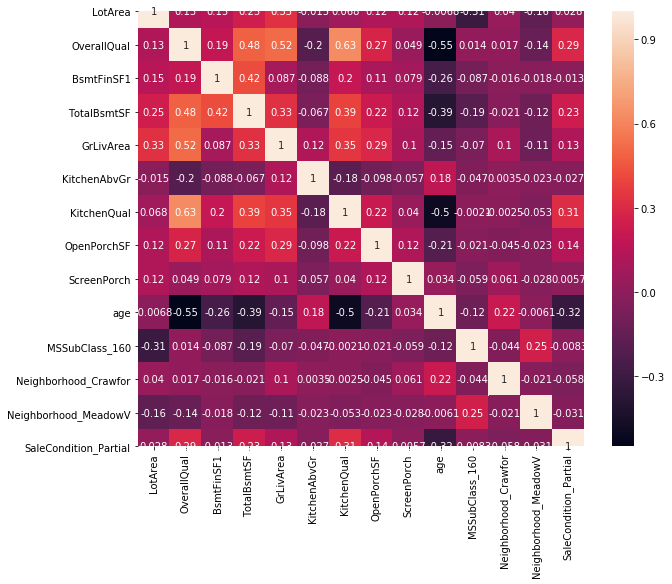

In [164]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train[top_features].corr(),annot=True)
plt.show()

In [165]:
top_features=top_features.drop('TotalBsmtSF')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     544.2
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:18   Log-Likelihood:                 663.27
No. Observations:                 990   AIC:                            -1299.
Df Residuals:                     976   BIC:                            -1230.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.4016      0.020    571.595      0.000      11.362      11.441
LotArea                   0.4483      0.063      7.172      0.000       0.326       0.571
OverallQual               0.5550      0.035     15.946      0.000       0.487       0.623
BsmtFinSF1                0.2408      0.018     13.032      0.000       0.205       0.277
GrLivArea                 0.8347      0.033     25.626      0.000       0.771       0.899
KitchenAbvGr             -0.2121      0.039     -5.508      0.000      -0.288      -0.137
KitchenQual               0.2059      0.025      8.078      0.000       0.156       0.256
OpenPorchSF               0.1304      0.037      3.556      0.000       0.058       0.202
ScreenPorch               0.1207      0.034      3.515      0.000       0.053       0.188
age                      -0.4165      0.025    -16.961      0.000      -0.465      -0.368
MSSubClass_160           -0.1394      0.021     -6.691      0.000      -0.180      -0.098
Neighborhood_Crawfor      0.1784      0.021      8.377      0.000       0.137       0.220
Neighborhood_MeadowV     -0.1449      0.040     -3.642      0.000      -0.223      -0.067
SaleCondition_Partial     0.0734      0.016      4.513      0.000       0.041       0.105
==============================================================================
Omnibus:                      196.283   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              644.109
Skew:                          -0.951   Prob(JB):                    1.36e-140
Kurtosis:                       6.464   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
printVIF(top_features,X_train)

                 Features    VIF
1             OverallQual  13.85
5             KitchenQual  10.38
3               GrLivArea   8.09
0                 LotArea   4.56
8                     age   2.26
2              BsmtFinSF1   2.22
6             OpenPorchSF   1.78
12  SaleCondition_Partial   1.29
9          MSSubClass_160   1.20
4            KitchenAbvGr   1.19
7             ScreenPorch   1.12
10   Neighborhood_Crawfor   1.11
11   Neighborhood_MeadowV   1.10


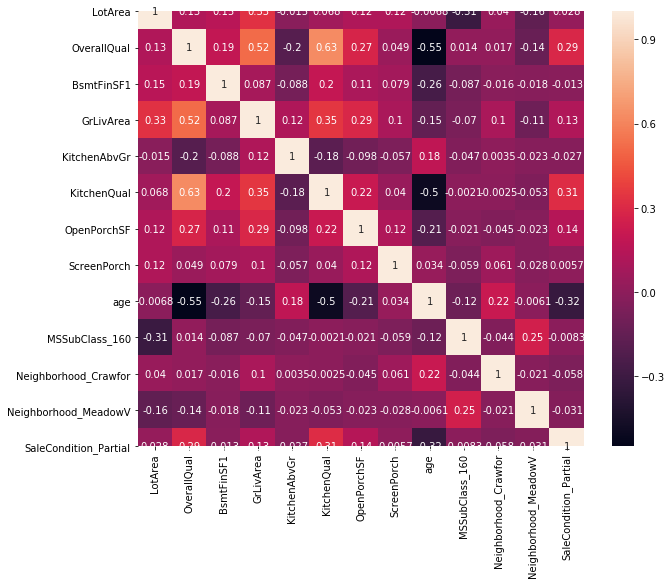

In [167]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train[top_features].corr(),annot=True)
plt.show()

In [168]:
top_features=top_features.drop('OverallQual')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     451.4
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:21   Log-Likelihood:                 548.67
No. Observations:                 990   AIC:                            -1071.
Df Residuals:                     977   BIC:                            -1008.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.5489      0.020    582.143      0.000      11.510      11.588
LotArea                   0.3913      0.070      5.588      0.000       0.254       0.529
BsmtFinSF1                0.2481      0.021     11.968      0.000       0.207       0.289
GrLivArea                 1.0635      0.033     32.415      0.000       0.999       1.128
KitchenAbvGr             -0.3315      0.042     -7.820      0.000      -0.415      -0.248
KitchenQual               0.3490      0.027     13.034      0.000       0.296       0.402
OpenPorchSF               0.1505      0.041      3.659      0.000       0.070       0.231
ScreenPorch               0.1186      0.039      3.077      0.002       0.043       0.194
age                      -0.5573      0.026    -21.681      0.000      -0.608      -0.507
MSSubClass_160           -0.1327      0.023     -5.678      0.000      -0.179      -0.087
Neighborhood_Crawfor      0.2057      0.024      8.635      0.000       0.159       0.252
Neighborhood_MeadowV     -0.2338      0.044     -5.288      0.000      -0.320      -0.147
SaleCondition_Partial     0.0909      0.018      4.996      0.000       0.055       0.127
==============================================================================
Omnibus:                      107.542   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.395
Skew:                          -0.630   Prob(JB):                     3.82e-53
Kurtosis:                       5.065   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
printVIF(top_features,X_train)

                 Features   VIF
2               GrLivArea  6.50
4             KitchenQual  6.09
0                 LotArea  4.52
7                     age  2.25
1              BsmtFinSF1  2.18
5             OpenPorchSF  1.78
11  SaleCondition_Partial  1.28
8          MSSubClass_160  1.18
3            KitchenAbvGr  1.16
6             ScreenPorch  1.12
9    Neighborhood_Crawfor  1.11
10   Neighborhood_MeadowV  1.09


In [170]:
top_features=top_features.drop('KitchenQual')
X_train_sm= sm.add_constant(X_train[top_features])
lr=sm.OLS(y_train,X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     406.8
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:44:22   Log-Likelihood:                 469.32
No. Observations:                 990   AIC:                            -914.6
Df Residuals:                     978   BIC:                            -855.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.7176      0.016    719.686      0.000      11.686      11.750
LotArea                   0.3215      0.076      4.252      0.000       0.173       0.470
BsmtFinSF1                0.2703      0.022     12.086      0.000       0.226       0.314
GrLivArea                 1.1949      0.034     35.341      0.000       1.129       1.261
KitchenAbvGr             -0.4247      0.045     -9.386      0.000      -0.514      -0.336
OpenPorchSF               0.1650      0.045      3.706      0.000       0.078       0.252
ScreenPorch               0.1232      0.042      2.952      0.003       0.041       0.205
age                      -0.6824      0.026    -26.423      0.000      -0.733      -0.632
MSSubClass_160           -0.1458      0.025     -5.768      0.000      -0.195      -0.096
Neighborhood_Crawfor      0.2289      0.026      8.899      0.000       0.178       0.279
Neighborhood_MeadowV     -0.2476      0.048     -5.175      0.000      -0.342      -0.154
SaleCondition_Partial     0.1338      0.019      6.902      0.000       0.096       0.172
==============================================================================
Omnibus:                       76.574   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.222
Skew:                          -0.439   Prob(JB):                     1.64e-40
Kurtosis:                       4.916   Cond. No.                         18.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
printVIF(top_features,X_train)

                 Features   VIF
2               GrLivArea  4.81
0                 LotArea  4.39
6                     age  2.22
1              BsmtFinSF1  1.96
4             OpenPorchSF  1.76
10  SaleCondition_Partial  1.18
7          MSSubClass_160  1.15
3            KitchenAbvGr  1.13
5             ScreenPorch  1.11
8    Neighborhood_Crawfor  1.11
9    Neighborhood_MeadowV  1.09


## Ridge

In [172]:
# create model with ridge
ridge=Ridge()
folds=5
params={'alpha':[0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,50,100,500,1000]}
ridge_cv=GridSearchCV(estimator=ridge,param_grid=params,
                     scoring='neg_mean_absolute_error',cv=folds,
                     return_train_score=True,verbose=1)
ridge_cv.fit(X_train[top_features],y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5,
                                   6, 7, 8, 9, 10, 20, 50, 100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [173]:
cv_results=pd.DataFrame(ridge_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003800,0.001167,0.001200,0.000401,0.0001,{'alpha': 0.0001},-0.110440,-0.117676,-0.126140,-0.116957,...,-0.114064,0.008990,9,-0.112543,-0.110520,-0.108825,-0.110667,-0.115092,-0.111529,0.002135
1,0.002999,0.000632,0.001800,0.000399,0.001,{'alpha': 0.001},-0.110441,-0.117676,-0.126139,-0.116957,...,-0.114064,0.008989,8,-0.112543,-0.110520,-0.108825,-0.110667,-0.115092,-0.111529,0.002135
2,0.003002,0.000633,0.001399,0.000492,0.01,{'alpha': 0.01},-0.110445,-0.117674,-0.126127,-0.116954,...,-0.114062,0.008985,7,-0.112541,-0.110520,-0.108824,-0.110668,-0.115089,-0.111529,0.002134
3,0.005201,0.003655,0.002600,0.002245,0.05,{'alpha': 0.05},-0.110465,-0.117668,-0.126078,-0.116942,...,-0.114054,0.008967,6,-0.112534,-0.110522,-0.108823,-0.110673,-0.115079,-0.111526,0.002130
4,0.004000,0.001095,0.001600,0.000489,0.1,{'alpha': 0.1},-0.110491,-0.117660,-0.126017,-0.116928,...,-0.114044,0.008944,5,-0.112530,-0.110525,-0.108822,-0.110681,-0.115069,-0.111525,0.002126


In [174]:
ridge_cv.best_score_
ridge_cv.best_score_

-0.11401498725996324

In [175]:
ridge_cv.best_params_

{'alpha': 0.3}

In [176]:
cv_results=cv_results[cv_results['param_alpha']<200]

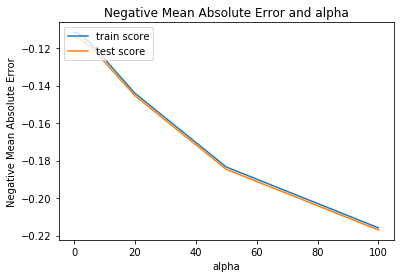

In [177]:
cv_results['param_alpha']=cv_results['param_alpha'].astype('int32')
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Negative Mean Absolute Error and alpha')
plt.legend(['train score','test score'],loc='upper left')
plt.show()

In [178]:
alpha=0.3
ridge=Ridge(alpha=alpha)
ridge.fit(X_train[top_features],y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [179]:
# get r2 score
y_train_pred= ridge.predict(X_train[top_features])

In [180]:
train_r2score= metrics.r2_score(y_train,y_train_pred)
print(train_r2score)

0.8205639940604886


In [181]:
y_test_pred=ridge.predict(X_test[top_features])
test_r2score= metrics.r2_score(y_test,y_test_pred)
print(test_r2score)

0.845016193710789


In [182]:
arr=ridge.coef_
count=0
ridge_coef={}
for ind,i in enumerate(arr):
    if ~(i==0):
        count=count+1
        ridge_coef[X_train[top_features].columns[ind]]=i
print(count)

11


In [183]:
ridge_coef['intercept']=ridge.intercept_

In [184]:
ridge_coef

{'LotArea': 0.3130682241826442,
 'BsmtFinSF1': 0.27105024981641146,
 'GrLivArea': 1.1815170763540102,
 'KitchenAbvGr': -0.4126195765594612,
 'OpenPorchSF': 0.1689731868221309,
 'ScreenPorch': 0.12308248782957068,
 'age': -0.6794968628599032,
 'MSSubClass_160': -0.14624278710785282,
 'Neighborhood_Crawfor': 0.22787738894841333,
 'Neighborhood_MeadowV': -0.24344465192970063,
 'SaleCondition_Partial': 0.13497304017413347,
 'intercept': 11.72109218304716}

### Lasso

In [185]:
lasso=Lasso()

In [186]:
# create model with lasso
folds=5
lasso_cv=GridSearchCV(estimator=lasso,param_grid=params,
                     scoring='neg_mean_absolute_error',cv=folds,
                     return_train_score=True,verbose=1)
lasso_cv.fit(X_train[top_features],y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5,
                                   6, 7, 8, 9, 10, 20, 50, 100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [187]:
cv_results=pd.DataFrame(lasso_cv.cv_results_)
cv_results=cv_results[cv_results['param_alpha']<10]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003001,9.702201e-07,0.001600,0.000799,0.0001,{'alpha': 0.0001},-0.110423,-0.117452,-0.125992,-0.117398,...,-0.114095,0.008930,1,-0.112566,-0.110554,-0.108869,-0.110680,-0.115127,-0.111559,0.002134
1,0.003400,4.905841e-04,0.001201,0.000400,0.001,{'alpha': 0.001},-0.111048,-0.117065,-0.124842,-0.122047,...,-0.115119,0.008648,2,-0.113754,-0.111360,-0.109977,-0.111528,-0.116362,-0.112596,0.002239
2,0.003199,9.805069e-04,0.001601,0.000491,0.01,{'alpha': 0.01},-0.144608,-0.138266,-0.148318,-0.153445,...,-0.143626,0.007083,3,-0.143364,-0.144193,-0.140631,-0.140992,-0.144936,-0.142823,0.001720
3,0.003000,9.841808e-07,0.001200,0.000400,0.05,{'alpha': 0.05},-0.304961,-0.280308,-0.289479,-0.286068,...,-0.286317,0.011274,4,-0.279765,-0.286259,-0.284912,-0.285111,-0.289264,-0.285062,0.003072
4,0.003000,6.329388e-04,0.001401,0.000490,0.1,{'alpha': 0.1},-0.304961,-0.280308,-0.289479,-0.286068,...,-0.286317,0.011274,4,-0.279765,-0.286259,-0.284912,-0.285111,-0.289264,-0.285062,0.003072


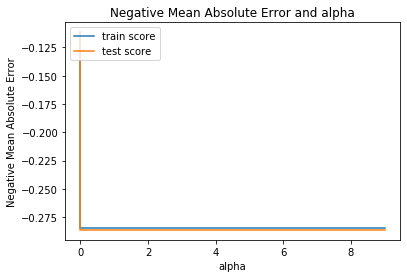

In [188]:
cv_results['param_alpha']=cv_results['param_alpha'].astype('int32')
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Negative Mean Absolute Error and alpha')
plt.legend(['train score','test score'],loc='upper left')
plt.show()

In [189]:
lasso_cv.best_params_

{'alpha': 0.0001}

In [190]:
alpha =0.0001
lasso= Lasso(alpha=alpha)
lasso.fit(X_train[top_features],y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [191]:
arr=lasso.coef_
count=0
lasso_coef={}
for ind,i in enumerate(arr):
    if ~(i==0):
        count=count+1
        lasso_coef[X_train[top_features].columns[ind]]=i
print(count)

11


In [192]:
lasso_coef['intercept']=lasso.intercept_

In [193]:
lasso.intercept_

11.719520394448518

In [194]:
# r2score on train data
lasso_train_pred= lasso.predict(X_train[top_features])
lasso_train_r2score= metrics.r2_score(y_train,lasso_train_pred)
lasso_train_r2score

0.8205912886007884

In [195]:
# r2score on test data
lasso_test_pred= lasso.predict(X_test[top_features])
lasso_test_r2score= metrics.r2_score(y_test,lasso_test_pred)
lasso_test_r2score

0.8452734370566851

In [196]:
lasso_coef

{'LotArea': 0.3057204613235849,
 'BsmtFinSF1': 0.2702133910347825,
 'GrLivArea': 1.1954197777988813,
 'KitchenAbvGr': -0.41796213659986353,
 'OpenPorchSF': 0.16046288072739243,
 'ScreenPorch': 0.1183569121474998,
 'age': -0.6811100206299725,
 'MSSubClass_160': -0.1461495721685714,
 'Neighborhood_Crawfor': 0.22622654125514555,
 'Neighborhood_MeadowV': -0.24032666583170104,
 'SaleCondition_Partial': 0.1331327320451184,
 'intercept': 11.719520394448518}

### Residual Analysis

Text(0.5, 0, 'Errors')

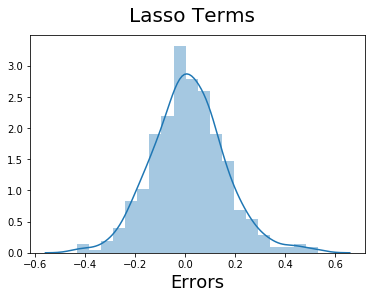

In [197]:
fig = plt.figure()
sns.distplot((y_test - lasso_test_pred), bins = 20)
# Plot heading
fig.suptitle('Lasso Terms', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)

#### Error terms are normally distributted with mean zero

Text(0.5, 0, 'Errors')

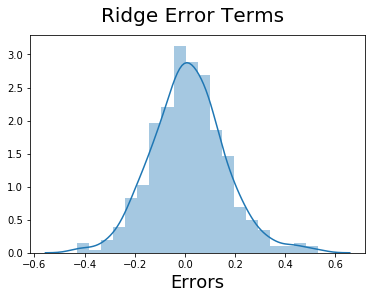

In [198]:
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
# Plot heading
fig.suptitle('Ridge Error Terms', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)

## We will use Lasso Regression

### Model can be predicted with following formula

#### math.exp(11.719520394448518+LotArea*(0.3057204613235849)+BsmtFinSF1*(0.2702133910347825)
#### +GrLivArea*(1.1954197777988813)+KitchenAbvGr*(-0.41796213659986353)+OpenPorchSF*(0.16046288072739243)
#### +ScreenPorch*(0.1183569121474998)+age*(-0.6811100206299725)+MSSubClass_160*(-0.1461495721685714)
#### +Neighborhood_Crawfor*(0.22622654125514555)+Neighborhood_MeadowV*(-0.24032666583170104)+SaleCondition_Partial*(0.1331327320451184))